# TACO WASTE DETECTION WITH YOLO MODELS (v5 to v12)

In [1]:
# Install libraries

import os
import json
import shutil
import random
import time
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Install required packages
!pip install ultralytics
!pip install pycocotools

# Import YOLO
from ultralytics import YOLO

print("Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

## Download the TACO dataset from Github

- Original dataset: https://github.com/pedropro/TACO
- Reference paper: https://arxiv.org/abs/2003.06975

In [2]:
# Clone TACO repository
!git clone https://github.com/pedropro/TACO.git

# Download dataset images
os.chdir('TACO')
!python download.py

# Check dataset structure
print("Dataset downloaded successfully!")
print(f"Number of images: {len(os.listdir('data'))}")

# Load annotations
with open('data/annotations.json', 'r') as f:
    coco_data = json.load(f)

print(f"Number of images in annotations: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}")

# Display sample categories
print("\nSample categories:")
for i, cat in enumerate(coco_data['categories'][:10]):
    print(f"  {cat['id']}: {cat['name']}")

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 740 (delta 416), reused 380 (delta 380), pack-reused 305 (from 1)
Receiving objects: 100% (740/740), 97.48 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (499/499), done.
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished
Dataset downloaded successfully!
Number of images: 18
Number of images in annotations: 1500
Number of annotations: 4784
Number of categories: 60

Sample categories:
  0: Aluminium foil
  1: Battery
  2: Aluminium blister pack
  3: Carded blister pack
  4: Other plastic bottle
  5: Clear plastic bottle
  6: Glass bottle
  7: Plastic bottle cap
  8: Metal bottle cap
  9: Broken glass


## Convert to YOLO format

In [3]:
def create_directory_structure(output_root):
    """Create required directory structure for YOLO dataset"""
    splits = ['train', 'valid', 'test']
    subdirs = ['images', 'labels']
    
    for split in splits:
        for subdir in subdirs:
            dir_path = os.path.join(output_root, split, subdir)
            os.makedirs(dir_path, exist_ok=True)
    print(f"Created directory structure at {output_root}")

def convert_bbox_to_yolo(bbox, image_width, image_height):
    """Convert COCO bbox format (x,y,w,h) to YOLO format (x_center,y_center,width,height normalized)"""
    x, y, width, height = bbox
    x_center = (x + width / 2) / image_width
    y_center = (y + height / 2) / image_height
    norm_width = width / image_width
    norm_height = height / image_height
    return [x_center, y_center, norm_width, norm_height]

def split_dataset(image_ids, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, seed=42):
    """Split image IDs into train, validation, and test sets"""
    random.seed(seed)
    ids = image_ids.copy()
    random.shuffle(ids)
    
    total = len(ids)
    n_train = int(train_ratio * total)
    n_val = int(val_ratio * total)
    
    train_ids = ids[:n_train]
    valid_ids = ids[n_train:n_train + n_val]
    test_ids = ids[n_train + n_val:]
    
    return {
        'train': train_ids,
        'valid': valid_ids,
        'test': test_ids
    }

def process_taco_dataset():
    """Process TACO dataset and convert to YOLO format"""
    
    # Load COCO annotations
    with open('data/annotations.json', 'r') as f:
        coco_data = json.load(f)
    
    images = coco_data['images']
    annotations = coco_data['annotations']
    
    # Create image metadata map
    image_metadata_map = {img['id']: img for img in images}
    
    # Group annotations by image ID
    image_annotations_map = defaultdict(list)
    for ann in annotations:
        image_annotations_map[ann['image_id']].append(ann)
    
    # Split dataset
    image_ids = list(image_metadata_map.keys())
    split_ids = split_dataset(image_ids)
    
    # Create output directory
    output_root = '../taco_yolo_dataset'
    create_directory_structure(output_root)
    
    # Process each split
    for split_name, ids in split_ids.items():
        print(f"Processing {split_name} split: {len(ids)} images")
        
        for i, img_id in enumerate(ids):
            image_metadata = image_metadata_map[img_id]
            image_annotations = image_annotations_map.get(img_id, [])
            
            # Copy image
            source_path = os.path.join('data', image_metadata['file_name'])
            if os.path.exists(source_path):
                dest_path = os.path.join(output_root, split_name, 'images', f"{i:06d}.jpg")
                shutil.copy(source_path, dest_path)
                
                # Create label file
                label_path = os.path.join(output_root, split_name, 'labels', f"{i:06d}.txt")
                with open(label_path, 'w') as f:
                    for ann in image_annotations:
                        # Convert to YOLO format (single class: litter = 0)
                        yolo_bbox = convert_bbox_to_yolo(
                            ann['bbox'], 
                            image_metadata['width'], 
                            image_metadata['height']
                        )
                        bbox_str = ' '.join(f'{coord:.6f}' for coord in yolo_bbox)
                        f.write(f"0 {bbox_str}\n")
    
    # Create dataset.yaml
    yaml_content = f"""# TACO Dataset for YOLO Training
# Single class waste detection

train: ../taco_yolo_dataset/train/images
val: ../taco_yolo_dataset/valid/images
test: ../taco_yolo_dataset/test/images

nc: 1
names: ['litter']
"""
    
    with open(os.path.join(output_root, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)
    
    print(f"Dataset conversion complete! Output: {output_root}")
    return output_root

# Process the dataset
dataset_path = process_taco_dataset()

Created directory structure at ../taco_yolo_dataset
Processing train split: 1050 images
Processing valid split: 150 images
Processing test split: 300 images
Dataset conversion complete! Output: ../taco_yolo_dataset


## YOLO model training

In [4]:
# Define models to train
models_to_train = [
    'yolov5nu.pt',  # YOLOv5 nano
    'yolov5su.pt',  # YOLOv5 small
    'yolov5n6u.pt',  # YOLOv5v6 nano
    'yolov5s6u.pt',  # YOLOv5v6 small
    'yolov8n.pt',   # YOLOv8 nano
    'yolov8s.pt'   # YOLOv8 small
   # 'yolov9t.pt',   # YOLOv9 tiny
  #  'yolov9s.pt',   # YOLOv9 small
  #  'yolo11n.pt',   # YOLOv11 nano
   # 'yolo11s.pt',   # YOLOv11 small
  #  'yolo12n.pt',   # YOLOv12 nano
   # 'yolo12s.pt'    # YOLOv12 small
]

# Adapt image_size to model
def get_imgsz(model_name):
    if model_name in ['yolov5n6u.pt', 'yolov5s6u.pt']:
        return 1280
    else:
        return 640

# Training configuration as in the paper
training_config = {
    'epochs': 100,
    'batch': -1,  # Auto batch size
    'patience': 100,
    'save_period': 10,
    'augment': True,
    'flipud': 0.5,
    'degrees': 10,
    'copy_paste': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1
    # imgsz will be set per model using get_imgsz(model_name)
}

# Results storage
training_results = {}

def train_yolo_model(model_name, data_yaml, config):
    """Train a YOLO model and return results"""
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*50}")
    
    # Initialize model
    model = YOLO(model_name)

    # Select image size dynamically
    imgsz = get_imgsz(model_name)
    
    # Start training timer
    start_time = time.time()
    
    # Train model
    results = model.train(
        data=data_yaml,
        epochs=config['epochs'],
        imgsz=imgsz,
        batch=config['batch'],
        patience=config['patience'],
        save_period=config['save_period'],
        augment=config['augment'],
        flipud=config['flipud'],
        degrees=config['degrees'],
        copy_paste=config['copy_paste'],
        mosaic=config['mosaic'],
        mixup=config['mixup'],
        project='runs/train',
        name=f'{model_name.replace(".pt", "")}',
        exist_ok=True
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Validate model
    val_results = model.val()
    
    # Get model size
    model_path = results.save_dir / 'weights' / 'best.pt'
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
    
    return {
        'model_name': model_name,
        'training_time': training_time,
        'model_size_mb': model_size,
        'results': results,
        'val_results': val_results,
        'best_model_path': str(model_path)
    }

# Train all models
data_yaml = '../taco_yolo_dataset/dataset.yaml'

for model_name in models_to_train:
    try:
        result = train_yolo_model(model_name, data_yaml, training_config)
        training_results[model_name] = result
        print(f"✅ {model_name} training completed successfully!")
    except Exception as e:
        print(f"❌ {model_name} training failed: {str(e)}")
        training_results[model_name] = {'error': str(e)}

print("\n🎉 All model training completed!")


TRAINING YOLOV5NU.PT


100%|██████████| 5.31M/5.31M [00:00<00:00, 16.0MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov5nu.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5nu, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

100%|██████████| 755k/755k [00:00<00:00, 4.15MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2020.3±1023.8 MB/s, size: 1969.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<00:00, 1184.75it/s]

train: New cache created: /kaggle/working/taco_yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.12G reserved, 0.07G allocated, 15.70G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2508659       7.177         0.411         43.55         149.7        (1, 3, 640, 640)                    list
     2508659       14.35         0.554         24.14          74.8        (2, 3, 640, 640)                    list
     2508659       28.71         0.898         27.15         110.5        (4, 3, 640, 640)                    list
     2508659       57.41         1.453         28.14         76.54        (8, 3, 640, 640)                    list
     2508659       114.

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1030.4±466.0 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 1014.01it/s]

val: New cache created: /kaggle/working/taco_yolo_dataset/valid/labels.cache


Plotting labels to runs/train/yolov5nu/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00040625000000000004), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/yolov5nu
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.42G      1.661      2.929      1.424         74        640: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]

                   all        150        529    0.00662      0.563      0.148     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.28G       1.52      2.134      1.335         44        640: 100%|██████████| 21/21 [00:26<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        150        529      0.747     0.0359      0.108     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.29G       1.58      2.037      1.344         76        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        150        529      0.348      0.227      0.171     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       7.3G      1.671      2.014      1.413         69        640: 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529     0.0976      0.127     0.0652     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.32G      1.681      1.983      1.423         46        640: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.268      0.157      0.122     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.33G      1.669      1.925       1.43         50        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.223      0.217      0.117     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G      1.704      1.891      1.448         54        640: 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.275      0.212      0.155     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.36G      1.649      1.834      1.417         44        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        150        529      0.386      0.285      0.246      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.38G      1.669      1.829      1.428         43        640: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529       0.39      0.302       0.28      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.39G      1.643      1.777      1.399         33        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        150        529       0.45      0.277      0.262      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       7.4G      1.658      1.807       1.41         47        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529      0.442      0.302      0.287      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.42G      1.636      1.792        1.4         75        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        150        529      0.474      0.308      0.291      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.43G      1.613      1.709      1.371         70        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529      0.404      0.316      0.257      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.45G       1.59      1.686      1.369         88        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529      0.576      0.298       0.31      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.46G      1.578      1.714      1.374         45        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.543      0.276      0.287      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.48G      1.572      1.659      1.351         61        640: 100%|██████████| 21/21 [00:26<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        150        529      0.426      0.308      0.308      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.49G      1.572      1.638      1.355         55        640: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529       0.48      0.365      0.353      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.51G      1.565      1.664      1.358         76        640: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        150        529       0.56       0.34      0.335      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.52G      1.577      1.645       1.36         97        640: 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        150        529      0.563      0.355      0.365      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.53G      1.545      1.584      1.348         35        640: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        150        529      0.521      0.359      0.364      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.55G      1.554      1.596      1.352         47        640: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        150        529      0.518      0.365      0.364       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.56G      1.505      1.558      1.325         64        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        150        529      0.536      0.366      0.361      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.58G      1.517      1.529      1.317         44        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        150        529      0.481      0.399      0.389      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.59G      1.532      1.549      1.318         81        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529      0.545      0.376       0.37      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.61G      1.489      1.528      1.313         44        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        150        529      0.538      0.371      0.367      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.62G      1.516      1.543      1.328         55        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        150        529      0.597      0.346      0.384      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.63G      1.535      1.552      1.329         45        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        150        529      0.551       0.35      0.367      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.65G      1.502      1.545      1.307         72        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        150        529      0.533      0.386      0.402      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.66G      1.472        1.5      1.289         67        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.574       0.35      0.394      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.68G      1.495      1.508      1.317         69        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.559      0.391      0.402      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.69G      1.508      1.516      1.305         79        640: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        150        529      0.576      0.355      0.387      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.71G      1.472      1.464      1.284         54        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        150        529      0.554      0.361      0.388      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.72G      1.474       1.47      1.285         87        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.571      0.327      0.362      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.73G      1.475      1.496      1.295         33        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all        150        529      0.576       0.39      0.404       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.75G      1.455      1.455      1.291         75        640: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        150        529      0.586      0.371      0.395      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.76G      1.459      1.431      1.287         48        640: 100%|██████████| 21/21 [00:28<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        150        529      0.526      0.382      0.399      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.78G      1.437      1.408      1.262        115        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        150        529      0.639      0.399      0.428      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.79G      1.443      1.422      1.277         53        640: 100%|██████████| 21/21 [00:28<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        150        529       0.52      0.418      0.429      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       7.8G      1.464       1.43       1.28         45        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        150        529      0.698      0.344      0.432      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.82G      1.475      1.427      1.296        115        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        150        529      0.616      0.371      0.413       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.83G      1.422      1.384      1.268         38        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        150        529      0.595      0.361      0.397      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.85G      1.427      1.398      1.273         52        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        150        529      0.657      0.361      0.432      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.86G      1.445      1.421      1.268         37        640: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        150        529      0.661      0.348      0.414      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.88G      1.424       1.39      1.267         56        640: 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.596      0.382      0.413      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.89G      1.425      1.389      1.253         60        640: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        150        529      0.659      0.403      0.444      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       7.9G      1.404      1.352      1.272         51        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        150        529      0.575      0.393      0.424      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.92G      1.396      1.337      1.251         41        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.635      0.393       0.44      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.93G      1.428      1.365      1.266         73        640: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.573      0.378       0.42      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.95G      1.418      1.345      1.256         74        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.585      0.415      0.443      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       6.5G       1.39      1.308      1.239         57        640: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        150        529      0.687      0.361      0.421      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.88G      1.381      1.317       1.24         55        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        150        529      0.602      0.389      0.426       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.88G      1.375      1.321      1.225         43        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.664      0.386      0.454      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.88G      1.385      1.324      1.246         38        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        150        529      0.645      0.414      0.467      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.88G      1.395      1.329      1.233         69        640: 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        150        529      0.654      0.389      0.453      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.88G      1.381       1.31      1.241         44        640: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        150        529      0.666      0.406       0.45      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.88G      1.365      1.261       1.23         32        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.669      0.393      0.464      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.88G      1.386      1.293      1.243         41        640: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        150        529      0.644      0.406      0.459      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.39G      1.402      1.317      1.246         47        640: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        150        529        0.6      0.414      0.431      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.39G      1.373      1.287      1.226         80        640: 100%|██████████| 21/21 [00:28<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        150        529      0.669      0.423      0.468      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.39G      1.376       1.29       1.23         45        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        150        529      0.616      0.389      0.459      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.39G      1.372      1.263      1.226        115        640: 100%|██████████| 21/21 [00:28<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        150        529      0.623       0.42      0.464      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.39G      1.381      1.302      1.237         33        640: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        150        529       0.63      0.401      0.459      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.39G      1.376      1.258      1.252         34        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all        150        529      0.663      0.365       0.44      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.39G      1.349      1.244      1.209         29        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        150        529       0.69      0.427      0.483      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.39G      1.363       1.25      1.212         46        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        150        529      0.712      0.403      0.475      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.39G      1.347      1.235      1.207         80        640: 100%|██████████| 21/21 [00:29<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        150        529      0.703      0.389      0.469      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.39G      1.363      1.251      1.216         64        640: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        150        529      0.658      0.408      0.468      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.39G      1.367      1.231      1.232         60        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.686      0.416      0.472      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.4G      1.315      1.197        1.2         72        640: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        150        529      0.716      0.391      0.468      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.42G      1.352      1.207      1.212         46        640: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all        150        529      0.601      0.406      0.461      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.43G      1.351      1.192      1.203         89        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        150        529      0.695      0.378      0.455      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.44G      1.339      1.205      1.198         39        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529       0.67      0.408      0.475      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.46G      1.304      1.194      1.194         43        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        150        529       0.67      0.406      0.469      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.47G      1.317      1.153      1.182         51        640: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        150        529      0.619      0.427      0.478      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.49G      1.318      1.147      1.193         71        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all        150        529      0.658      0.416      0.475      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       7.5G      1.332      1.173      1.188         79        640: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all        150        529      0.639      0.437      0.485       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.52G      1.307      1.154      1.197         58        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        150        529      0.629      0.432      0.477      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.53G      1.319      1.157      1.201         61        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        150        529      0.619      0.457      0.486      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.54G      1.301      1.146      1.189         84        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        150        529      0.684      0.423      0.477      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.56G        1.3      1.157      1.177         58        640: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529      0.726      0.405      0.489      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.57G      1.293       1.13      1.174         55        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all        150        529      0.713       0.41      0.486       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.59G      1.268      1.113      1.163         45        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        150        529      0.703      0.425      0.488      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       7.6G      1.286      1.115      1.178         29        640: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        150        529      0.677       0.41      0.484      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.62G       1.27      1.092      1.164         34        640: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        150        529       0.69      0.422      0.475      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.63G      1.305       1.14      1.187         43        640: 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        150        529      0.662      0.429      0.476       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.64G      1.261      1.117      1.166         44        640: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        150        529      0.674      0.416      0.487       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.66G       1.32      1.142       1.19         77        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        150        529      0.699       0.42      0.484      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.67G      1.249      1.098      1.144         64        640: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529      0.716      0.412      0.492      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.69G      1.245      1.087      1.157         44        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        150        529      0.647      0.456        0.5      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       7.7G      1.254      1.096       1.16         44        640: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        150        529      0.665      0.433      0.498      0.304


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.71G      1.161      1.023      1.095         21        640: 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.724      0.393      0.489      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.73G      1.163     0.9698      1.099         47        640: 100%|██████████| 21/21 [00:29<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        150        529      0.732      0.429      0.504      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.74G       1.17     0.9385      1.088         22        640: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        150        529      0.716      0.434      0.508      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.76G      1.167     0.9259      1.094         27        640: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        150        529      0.731      0.416      0.505      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.77G      1.134     0.9029      1.078         34        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        150        529      0.733      0.425      0.505      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.79G      1.139     0.9178      1.079         19        640: 100%|██████████| 21/21 [00:26<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        150        529      0.715      0.418      0.509      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       7.8G      1.145     0.9143      1.079         55        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        150        529      0.703      0.427      0.502      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.81G      1.147     0.9132      1.083         29        640: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.722      0.431      0.508      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.83G      1.121     0.8875      1.084         20        640: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        150        529      0.731      0.429       0.51      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.84G      1.111     0.8678      1.071         24        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        150        529      0.736      0.422      0.507      0.305



100 epochs completed in 0.842 hours.
Optimizer stripped from runs/train/yolov5nu/weights/last.pt, 5.3MB
Optimizer stripped from runs/train/yolov5nu/weights/best.pt, 5.3MB

Validating runs/train/yolov5nu/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.645      0.435      0.496      0.308
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/train/yolov5nu
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2132.6±1646.6 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.655      0.422      0.484      0.306
Speed: 5.1ms preprocess, 7.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/train/yolov5nu
✅ yolov5nu.pt training completed successfully!

TRAINING YOLOV5SU.PT


100%|██████████| 17.7M/17.7M [00:00<00:00, 44.7MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5su, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 1.89G reserved, 0.15G allocated, 13.84G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     9122579       24.04         0.998         23.33         74.31        (1, 3, 640, 640)                    list
     9122579       48.09         1.250         22.64         72.89        (2, 3, 640, 640)                    list
     9122579       96.17         1.984         26.66         85.44        (4, 3, 640, 640)                    list
     9122579       192.3         3.232         41.16         108.4        (8, 3, 640, 640)                    list
     9122579       384.7         5.843         76.44         172.6       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 22 for CUDA:0 9.83G/15.89G (62%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3633.1±159.5 MB/s, size: 1586.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 282.3±71.6 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/train/yolov5su/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.000515625), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/yolov5su
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.35G      1.594      2.268      1.391         92        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        150        529      0.362      0.287      0.199      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.35G      1.675      1.887      1.423        105        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        150        529     0.0437      0.301     0.0283     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.35G      1.776      1.977        1.5        127        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        150        529     0.0709      0.144     0.0359     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.35G      1.779      1.964      1.506         82        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529      0.259      0.238      0.158      0.074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.35G      1.702       1.87      1.459        114        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        150        529       0.28      0.254      0.151     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.35G       1.73      1.897      1.459        118        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        150        529      0.387      0.263      0.226      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.35G      1.675      1.815       1.43         61        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        150        529      0.489      0.242      0.272      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.35G      1.644       1.78      1.398         93        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        150        529      0.521      0.286      0.283      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.35G      1.659      1.812      1.417        102        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        150        529       0.49      0.318      0.313      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.35G      1.647      1.769      1.407         68        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        150        529      0.406      0.395      0.341      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.35G      1.672      1.787      1.429        143        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        150        529      0.462      0.308      0.297      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.35G       1.59      1.693      1.381         77        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        150        529      0.507      0.331      0.354      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.35G      1.574      1.647      1.372         73        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.535      0.371      0.375      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.35G      1.582      1.649      1.367        168        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        150        529      0.445      0.356      0.339      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.38G      1.572      1.645      1.361         71        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.466      0.382      0.377      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.41G      1.582      1.653      1.379         74        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        150        529      0.576      0.329      0.366      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.41G      1.556      1.633      1.352         86        640: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        150        529      0.561      0.376      0.397       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.41G      1.527      1.559      1.338         84        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        150        529      0.531      0.391      0.407      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.41G      1.552      1.633      1.363         96        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        150        529      0.557      0.388      0.424      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.44G      1.516      1.556       1.34        107        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        150        529      0.535      0.395        0.4       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.47G      1.508      1.564      1.328        104        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        150        529      0.597      0.336       0.37      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.47G      1.507      1.552      1.341         66        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        150        529      0.546      0.348      0.371      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.47G      1.498      1.539      1.321         66        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        150        529      0.652      0.344      0.416      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.47G      1.498      1.519      1.313         80        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        150        529      0.539      0.402      0.427       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.47G      1.496      1.506       1.31        108        640: 100%|██████████| 48/48 [00:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        150        529      0.638      0.367      0.421      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.47G      1.513      1.558      1.312        117        640: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        150        529      0.542       0.41       0.42      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.47G      1.468        1.5      1.306        111        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        150        529      0.488      0.408      0.391      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.47G       1.48        1.5      1.318        130        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        150        529       0.64      0.376      0.432      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.47G      1.453       1.45      1.282        123        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        150        529      0.618      0.391      0.435      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.47G       1.47      1.494      1.297        104        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        150        529      0.568      0.401       0.43      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.47G      1.503      1.484      1.315         77        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        150        529      0.623      0.375      0.415       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.47G      1.463       1.47      1.293         90        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.578      0.388       0.42      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.47G      1.425      1.411      1.276        117        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        150        529      0.536      0.378      0.375      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.47G      1.474      1.446      1.318         95        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        150        529      0.549      0.414      0.431      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.47G      1.445      1.432      1.304         83        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        150        529      0.563      0.363      0.398      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.47G      1.431      1.396      1.265         80        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.677      0.397       0.46      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.47G      1.405       1.37      1.275        112        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        150        529      0.561      0.416       0.45       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.47G      1.402      1.367      1.263        118        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.573      0.401      0.429       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.47G      1.457      1.444      1.282         83        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        150        529      0.641      0.369      0.434      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.47G        1.4      1.377      1.256         58        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        150        529      0.627      0.378      0.429      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.47G      1.407      1.365      1.267         95        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        150        529      0.574       0.42      0.444      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.47G      1.393      1.348      1.245        108        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        150        529      0.616      0.423      0.459      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.47G      1.409       1.34      1.259        120        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        150        529      0.576      0.439      0.471      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.47G      1.401      1.352      1.267         82        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        150        529      0.657      0.397      0.459      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.47G      1.399       1.36      1.264         92        640: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.645       0.44       0.49       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.47G      1.411      1.358       1.27        165        640: 100%|██████████| 48/48 [00:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        150        529      0.576      0.459      0.472      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.48G      1.394      1.352      1.256         77        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        150        529      0.588      0.456      0.484       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.48G      1.382      1.302      1.249         80        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        150        529      0.624      0.414      0.459      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.48G      1.392      1.308      1.258         92        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        150        529      0.615       0.45      0.483      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.48G      1.363      1.285      1.233         78        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.596      0.444      0.473       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.48G       1.36      1.293       1.22        106        640: 100%|██████████| 48/48 [00:32<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.591      0.421      0.468      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.48G      1.327      1.257      1.233        121        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        150        529      0.611      0.461       0.49      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.48G       1.38        1.3      1.232         71        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        150        529      0.607       0.45      0.485       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.48G      1.373      1.277       1.24        127        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        150        529       0.56      0.437      0.462      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.48G      1.341      1.235      1.224         69        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        150        529      0.633      0.429       0.48      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.48G      1.367      1.262      1.224         65        640: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.594      0.439      0.473      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.48G      1.344      1.259      1.231        106        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.623      0.444      0.484      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.48G      1.338      1.227      1.208         91        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        150        529      0.591      0.454      0.481      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.48G      1.333       1.22      1.222         69        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        150        529      0.576      0.452      0.489      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.48G      1.365      1.229      1.238         89        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        150        529      0.573      0.448      0.463      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.48G       1.34      1.202      1.216         90        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.603      0.457       0.49      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.48G      1.329      1.217      1.211        107        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        150        529      0.718      0.416      0.493      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.48G      1.312      1.192      1.226         59        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        150        529      0.634      0.463      0.506       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.48G      1.339      1.215      1.219        138        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        150        529        0.7      0.433      0.502      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.48G      1.315      1.176      1.196         80        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        150        529       0.64       0.45        0.5       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.48G      1.298      1.154      1.188        106        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        150        529      0.658       0.45      0.493      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.48G      1.343      1.224      1.213        128        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        150        529      0.699      0.435      0.506      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.48G      1.307      1.183        1.2         66        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        150        529      0.648      0.441      0.494      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.48G      1.299      1.178      1.206        108        640: 100%|██████████| 48/48 [00:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        150        529      0.608      0.469      0.512      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.48G      1.298      1.168      1.195         81        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.612      0.488      0.518      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.48G      1.289      1.138      1.186        125        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        150        529      0.659      0.444      0.504      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.48G      1.304      1.148      1.194         67        640: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.645      0.482       0.51      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.48G      1.254      1.096      1.165        151        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        150        529      0.632      0.459        0.5      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.48G      1.281      1.138      1.178         75        640: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        150        529      0.677      0.457      0.502      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.48G      1.254      1.092      1.161         93        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        150        529      0.626      0.456      0.492      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.48G      1.277      1.123       1.17        117        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        150        529       0.68      0.412      0.481      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.48G      1.256      1.103      1.165        105        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        150        529      0.641      0.452      0.503      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.48G      1.245      1.109      1.175         64        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529       0.62      0.461      0.492      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.48G      1.273      1.095      1.175        119        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        150        529      0.624      0.455      0.497      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.48G       1.24      1.101      1.163        123        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        150        529       0.65      0.473        0.5      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.48G      1.239      1.082      1.149         50        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        150        529      0.701      0.452      0.516      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.48G      1.241       1.11       1.16         83        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        150        529      0.649      0.458      0.515      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.48G      1.209       1.06      1.144         71        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        150        529      0.663      0.457       0.51       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.48G      1.232      1.067      1.159         77        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        150        529      0.646       0.48      0.518      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.48G      1.219       1.06      1.167         87        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        150        529      0.715      0.448      0.527      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.48G       1.23      1.087      1.159        105        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        150        529      0.762      0.454      0.537      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.48G      1.221      1.053      1.163         72        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        150        529      0.676      0.473      0.533      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.48G      1.196      1.028      1.137         75        640: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529      0.664      0.482      0.535      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.48G      1.207      1.061      1.154         73        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        150        529      0.692      0.465      0.538      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.48G       1.18      1.006      1.134         88        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        150        529      0.671      0.503      0.539      0.345


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.48G      1.115     0.9725       1.08         35        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        150        529      0.679      0.474       0.53      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.48G      1.109     0.8921      1.078         61        640: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        150        529      0.692      0.471      0.522      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.48G      1.114      0.899      1.077         31        640: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        150        529      0.672      0.473       0.52      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.48G      1.077     0.8477      1.055         34        640: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.688      0.478      0.531      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.48G      1.074     0.8655      1.065         48        640: 100%|██████████| 48/48 [00:30<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        150        529      0.719      0.474      0.527      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.48G       1.08      0.849      1.063         39        640: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        150        529      0.734      0.454      0.527      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.48G       1.07     0.8356      1.061         99        640: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        150        529      0.683       0.49      0.532      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.48G      1.073     0.8457      1.059         38        640: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529      0.681      0.484      0.532      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.48G      1.058     0.8159       1.05         57        640: 100%|██████████| 48/48 [00:30<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        150        529      0.698      0.484      0.532      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.48G      1.056     0.8183      1.062         33        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.694      0.478      0.529      0.343



100 epochs completed in 1.009 hours.
Optimizer stripped from runs/train/yolov5su/weights/last.pt, 18.5MB
Optimizer stripped from runs/train/yolov5su/weights/best.pt, 18.5MB

Validating runs/train/yolov5su/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.669      0.499      0.538      0.351
Speed: 0.2ms preprocess, 15.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/train/yolov5su
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4579.4±971.9 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.663      0.495      0.537      0.351
Speed: 4.1ms preprocess, 16.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/train/yolov5su
✅ yolov5su.pt training completed successfully!

TRAINING YOLOV5N6U.PT


100%|██████████| 8.65M/8.65M [00:00<00:00, 26.4MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov5n6u.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5n6u, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 2.02G reserved, 0.25G allocated, 13.62G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     4133876       29.14         0.931         31.59         137.5      (1, 3, 1280, 1280)                    list
     4133876       58.28         1.579          33.1           130      (2, 3, 1280, 1280)                    list
     4133876       116.6         2.917         41.37         153.4      (4, 3, 1280, 1280)                    list
     4133876       233.1         5.100         76.47           213      (8, 3, 1280, 1280)                    list
     4133876       466.2         9.861         142.7         393.4     (16, 3, 1280, 1280)                    list
AutoBatch: Using batch-size 12 for CUDA:0 9.77G/15.89G (61%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3862.1±489.1 MB/s, size: 1586.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 625.2±15.1 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/train/yolov5n6u/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 91 weight(decay=0.0), 100 weight(decay=0.00046875), 99 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/train/yolov5n6u
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.42G      1.481      3.558      1.375         35       1280: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

                   all        150        529      0.373      0.198      0.171     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.26G      1.609      2.889      1.427         63       1280: 100%|██████████| 88/88 [00:59<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


                   all        150        529      0.392      0.282       0.24      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.26G      1.655      2.665      1.484         39       1280: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        150        529      0.371      0.282      0.247      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.26G      1.664      2.396      1.496         16       1280: 100%|██████████| 88/88 [00:58<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        150        529       0.37      0.301       0.25      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.27G      1.665      2.299      1.486         36       1280: 100%|██████████| 88/88 [00:58<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


                   all        150        529      0.471      0.289      0.282       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.27G      1.661      2.204      1.475         45       1280: 100%|██████████| 88/88 [01:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        150        529      0.462      0.318      0.308      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.27G      1.638      2.152      1.481         96       1280: 100%|██████████| 88/88 [01:00<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        150        529      0.451      0.333      0.311      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.27G      1.613      2.063      1.448         33       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        150        529      0.522      0.327      0.338      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.27G      1.598      2.014      1.445         23       1280: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        150        529       0.48      0.333      0.317      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.27G      1.606      2.013       1.44         33       1280: 100%|██████████| 88/88 [00:59<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        150        529      0.523      0.382      0.374      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.27G      1.571      2.001      1.422         68       1280: 100%|██████████| 88/88 [01:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        150        529      0.563      0.325      0.359      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.28G       1.55      1.943      1.418         62       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        150        529      0.549      0.331      0.374      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.29G      1.523      1.891       1.39         25       1280: 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        150        529      0.527      0.359      0.383      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.31G      1.511      1.865      1.379         56       1280: 100%|██████████| 88/88 [00:58<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        150        529      0.537      0.386      0.399      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.33G      1.501      1.865      1.384         31       1280: 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        150        529      0.547      0.386      0.409       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.33G      1.502      1.832      1.385         25       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        150        529      0.505      0.353      0.378      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.33G      1.486      1.791      1.372         49       1280: 100%|██████████| 88/88 [00:58<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        150        529      0.558      0.414      0.417      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.33G      1.487      1.797      1.373         59       1280: 100%|██████████| 88/88 [00:58<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


                   all        150        529      0.559      0.374      0.397      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.33G      1.522      1.874      1.404         37       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        150        529      0.609      0.393      0.436      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.33G      1.498       1.78      1.374         37       1280: 100%|██████████| 88/88 [01:00<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        150        529      0.621      0.387      0.446      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.33G      1.488      1.765      1.374         47       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        150        529      0.589      0.382      0.436      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.33G       1.47      1.745      1.372         20       1280: 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        150        529      0.551      0.408      0.436      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.33G       1.47      1.732      1.355         20       1280: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


                   all        150        529      0.563      0.415      0.449      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.33G      1.461      1.704      1.373         26       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        150        529      0.555      0.414      0.441      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.33G      1.472      1.726      1.368         31       1280: 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        150        529      0.644      0.389      0.471      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.33G      1.445      1.721      1.354         39       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        150        529      0.571      0.415      0.453      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.33G      1.442      1.718      1.359         52       1280: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


                   all        150        529      0.541      0.429      0.434      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.33G      1.459      1.747      1.348         48       1280: 100%|██████████| 88/88 [00:58<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        150        529      0.616      0.415       0.46      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.33G      1.441      1.665      1.348         54       1280: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


                   all        150        529      0.666      0.401      0.473      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.33G      1.434      1.679      1.337         52       1280: 100%|██████████| 88/88 [01:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        150        529      0.597      0.425      0.467      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.33G      1.442      1.698      1.337         93       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


                   all        150        529       0.62      0.417      0.476      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.33G      1.407      1.636      1.329         32       1280: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        150        529      0.663      0.384      0.469      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.33G      1.418      1.628      1.327         57       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


                   all        150        529      0.677      0.433      0.488      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.33G       1.43      1.646      1.322         23       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        150        529      0.564      0.439      0.446      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.34G        1.4      1.599      1.333         28       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        150        529      0.659      0.406      0.475      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.98G      1.404      1.616      1.318         21       1280: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        150        529      0.574      0.482      0.499      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.04G      1.378      1.562      1.304         32       1280: 100%|██████████| 88/88 [01:00<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        150        529      0.597      0.486      0.524        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.04G      1.387      1.604      1.314         64       1280: 100%|██████████| 88/88 [01:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        150        529      0.684      0.437      0.502      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.04G      1.395      1.602      1.315         24       1280: 100%|██████████| 88/88 [01:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


                   all        150        529      0.589      0.428      0.481      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.04G      1.386      1.565      1.294         21       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        150        529      0.629      0.465      0.512      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.58G      1.362      1.522      1.298         33       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        150        529      0.621      0.459        0.5      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.58G      1.378      1.542      1.302         62       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        150        529      0.638      0.457        0.5      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.59G      1.355       1.51      1.276         29       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        150        529       0.66      0.458      0.506      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.59G      1.356      1.546      1.278         32       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        150        529      0.636      0.448      0.497      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.6G      1.381      1.526      1.308         41       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        150        529      0.608      0.467      0.515      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.6G      1.372      1.555      1.297         28       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


                   all        150        529      0.685      0.431      0.514       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       6.6G      1.352      1.486       1.28         21       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        150        529      0.677      0.433      0.513      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.6G       1.35      1.498      1.291         37       1280: 100%|██████████| 88/88 [01:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        150        529      0.664      0.454      0.511      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.6G      1.368      1.524      1.286         15       1280: 100%|██████████| 88/88 [01:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


                   all        150        529      0.678      0.437      0.505      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       6.6G      1.349      1.476      1.282         45       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


                   all        150        529      0.698      0.428      0.515      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.6G      1.348      1.482      1.269         20       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


                   all        150        529       0.67      0.442      0.506      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.6G      1.344      1.498      1.283         42       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        150        529      0.643       0.45      0.516      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       6.6G      1.342      1.472       1.28         21       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        150        529      0.663      0.452      0.522      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       6.6G      1.342      1.439      1.263         37       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        150        529      0.612       0.45      0.506      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       6.6G       1.34      1.438      1.269         18       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        150        529      0.664      0.451      0.529      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.6G      1.332      1.404       1.25         53       1280: 100%|██████████| 88/88 [01:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        150        529      0.678      0.467      0.545      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.6G      1.349       1.43      1.278         47       1280: 100%|██████████| 88/88 [01:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        150        529      0.695      0.435       0.52      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.6G      1.311      1.399      1.265         25       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        150        529      0.672      0.452      0.525      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       6.6G      1.318      1.394       1.26         41       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        150        529      0.666      0.445      0.516      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.6G      1.332      1.427      1.266         48       1280: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        150        529      0.625      0.498      0.535      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.29G      1.328      1.401      1.256         35       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        150        529      0.689      0.459      0.529      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.32G      1.319      1.402      1.259         52       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        150        529      0.708      0.461      0.531      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.33G      1.307      1.396      1.264         21       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        150        529       0.72      0.461      0.557      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.33G      1.307      1.378      1.254        109       1280: 100%|██████████| 88/88 [01:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


                   all        150        529      0.706      0.456      0.547      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.33G      1.312      1.366      1.236         44       1280: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        150        529      0.661      0.476      0.535      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.33G      1.293      1.362      1.241         74       1280: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        150        529      0.634      0.461      0.522      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.33G      1.302      1.377      1.252         56       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        150        529      0.599      0.503      0.543      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.33G      1.311      1.348      1.247         22       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


                   all        150        529      0.714      0.462      0.553      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.33G      1.282      1.304      1.233         35       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        150        529      0.745       0.44      0.535      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.33G       1.28      1.322      1.233         69       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


                   all        150        529       0.74      0.473      0.553       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.33G      1.283      1.309      1.241         45       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        150        529      0.637      0.491      0.538      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.33G      1.279      1.292      1.237         34       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]

                   all        150        529      0.653      0.495      0.546      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.33G      1.288      1.293      1.242         51       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        150        529      0.705      0.474      0.551      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.33G      1.281       1.31      1.239         13       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


                   all        150        529      0.713       0.48      0.552      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.33G      1.255      1.252      1.222         39       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        150        529      0.758      0.471      0.569      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.33G      1.259      1.296      1.222         42       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        150        529      0.665      0.495      0.547      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.33G      1.268      1.264      1.216         23       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


                   all        150        529      0.691      0.456      0.543      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.33G      1.281      1.297      1.224         33       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        150        529      0.719      0.471      0.552      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.33G      1.269      1.228       1.23         36       1280: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        150        529      0.747      0.448      0.539      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.33G      1.262      1.268      1.228         42       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


                   all        150        529      0.715      0.473       0.55      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.33G      1.285      1.252      1.215         31       1280: 100%|██████████| 88/88 [00:59<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        150        529      0.699      0.469      0.551      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.33G      1.244      1.239      1.217         54       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


                   all        150        529      0.706      0.452      0.528      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.33G      1.227      1.202      1.203         35       1280: 100%|██████████| 88/88 [01:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        150        529      0.652      0.491      0.545      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.33G      1.252       1.23      1.207         27       1280: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        150        529      0.729      0.474      0.563      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.33G      1.235      1.223       1.21         25       1280: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        150        529      0.741      0.463      0.563      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.33G      1.238      1.217      1.201         40       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


                   all        150        529      0.662       0.49      0.554      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.33G      1.236      1.196      1.197         24       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        150        529      0.748      0.478      0.569      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.33G       1.23      1.195      1.197         43       1280: 100%|██████████| 88/88 [01:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        150        529      0.678       0.49      0.555      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.33G      1.235      1.208      1.216         31       1280: 100%|██████████| 88/88 [01:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        150        529      0.658      0.509      0.559      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.33G      1.208      1.171       1.18         22       1280: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        150        529      0.751      0.465      0.554      0.328


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.33G      1.139        1.1       1.12         11       1280: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        150        529      0.631      0.514       0.55      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.33G      1.129      1.036      1.115         46       1280: 100%|██████████| 88/88 [00:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        150        529      0.712      0.476      0.548      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.33G      1.139      1.033      1.121         13       1280: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        150        529      0.728      0.466      0.561      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.33G      1.136      1.006      1.112         18       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        150        529      0.742      0.473      0.563      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.33G      1.121      1.021      1.114         14       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        150        529      0.724      0.476      0.555      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.33G      1.113     0.9906      1.118         11       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]

                   all        150        529        0.7      0.482      0.561       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.33G      1.125     0.9933      1.111         47       1280: 100%|██████████| 88/88 [00:56<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        150        529       0.74      0.469      0.554      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.33G      1.121     0.9758       1.11         22       1280: 100%|██████████| 88/88 [00:55<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        150        529      0.763      0.456      0.562      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.33G      1.094     0.9541      1.101          9       1280: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        150        529      0.705      0.478      0.557      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.33G      1.116     0.9506      1.112         13       1280: 100%|██████████| 88/88 [00:56<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        150        529      0.701      0.474       0.55      0.318



100 epochs completed in 1.798 hours.
Optimizer stripped from runs/train/yolov5n6u/weights/last.pt, 8.6MB
Optimizer stripped from runs/train/yolov5n6u/weights/best.pt, 8.6MB

Validating runs/train/yolov5n6u/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.697      0.482      0.562      0.341
Speed: 0.5ms preprocess, 32.8ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/train/yolov5n6u
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4188.8±755.6 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.707      0.484      0.563      0.344
Speed: 5.2ms preprocess, 22.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/train/yolov5n6u
✅ yolov5n6u.pt training completed successfully!

TRAINING YOLOV5S6U.PT


100%|██████████| 29.6M/29.6M [00:02<00:00, 10.9MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov5s6u.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5s6u, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 2.37G reserved, 0.25G allocated, 13.27G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    15268564       97.79         1.887         38.56         154.1      (1, 3, 1280, 1280)                    list
    15268564       195.6         3.049         46.61         164.9      (2, 3, 1280, 1280)                    list
    15268564       391.2         5.090         77.24         223.6      (4, 3, 1280, 1280)                    list
    15268564       782.3         9.097         149.2         371.6      (8, 3, 1280, 1280)                    list
    15268564        1565        17.293         273.5         665.6     (16, 3, 1280, 1280)                    list
AutoBatch: Using batch-size 6 for CUDA:0 9.70G/15.89G (61%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3833.1±290.2 MB/s, size: 1586.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 340.4±125.1 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/train/yolov5s6u/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 91 weight(decay=0.0), 100 weight(decay=0.000515625), 99 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/train/yolov5s6u
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.38G       1.55       3.01      1.459         35       1280: 100%|██████████| 175/175 [01:22<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

                   all        150        529      0.396      0.261      0.241      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.38G      1.757      2.392      1.599         33       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


                   all        150        529     0.0577      0.287     0.0318      0.015

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.43G      1.789      2.386      1.603         43       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


                   all        150        529       0.33       0.27      0.221      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.44G      1.784      2.355      1.593         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


                   all        150        529      0.444      0.242      0.238     0.0969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.47G      1.739      2.269      1.532         45       1280: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]

                   all        150        529       0.51      0.268      0.275      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.47G      1.698      2.177      1.515         15       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]

                   all        150        529      0.367      0.276      0.245      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.47G      1.685      2.188      1.508         27       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


                   all        150        529      0.473      0.314      0.305      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.47G      1.652      2.086      1.472         21       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.86it/s]

                   all        150        529      0.546      0.293      0.323      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.48G      1.658      2.116      1.489         39       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]

                   all        150        529      0.555      0.293      0.336      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.48G        1.6      2.062      1.456         19       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]

                   all        150        529      0.508      0.306      0.315      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.48G      1.603      2.021      1.448         38       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]

                   all        150        529      0.499      0.348      0.347      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.54G      1.597      2.024      1.448         42       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]

                   all        150        529      0.481      0.353      0.365      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.54G      1.542        1.9      1.419         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]

                   all        150        529      0.561      0.365      0.404      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.54G      1.557      1.948      1.429         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

                   all        150        529      0.511      0.357      0.366       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.59G      1.553      1.951      1.443         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

                   all        150        529      0.607      0.338      0.392      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.59G      1.555      1.914      1.419         29       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


                   all        150        529      0.501      0.395      0.392      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.59G      1.502      1.836      1.387         38       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

                   all        150        529      0.513      0.369      0.366      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.59G      1.525      1.834      1.412         58       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


                   all        150        529      0.635      0.357      0.426      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.59G      1.549      1.893      1.412         52       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]

                   all        150        529      0.555      0.408      0.432      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.59G       1.51      1.831      1.395         22       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.79it/s]

                   all        150        529      0.528      0.422      0.441      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.59G       1.48      1.764      1.373         46       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

                   all        150        529      0.619      0.382      0.436      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.59G      1.488      1.774      1.377         12       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]

                   all        150        529      0.651      0.384      0.455      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.63G      1.495      1.777      1.373         30       1280: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


                   all        150        529      0.541      0.393      0.419      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.68G      1.456      1.722      1.359         38       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


                   all        150        529      0.601      0.378      0.444      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.68G      1.479      1.762       1.37         64       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


                   all        150        529      0.615      0.367      0.426       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.68G      1.474      1.753      1.371         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


                   all        150        529      0.591      0.393      0.448      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.68G      1.487      1.793      1.388         47       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.84it/s]

                   all        150        529      0.558      0.416      0.422      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.68G      1.448      1.726      1.358         29       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


                   all        150        529      0.626      0.416      0.463       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.68G      1.463      1.717      1.374         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

                   all        150        529      0.572      0.416      0.461      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.68G      1.444      1.725       1.35         34       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


                   all        150        529      0.606      0.423      0.456      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.68G      1.454      1.683       1.35         18       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


                   all        150        529        0.6      0.401      0.451      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.26G      1.408       1.65      1.323         27       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

                   all        150        529      0.653      0.418      0.483      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.26G      1.435      1.662       1.35         59       1280: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


                   all        150        529      0.588      0.444       0.48      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.26G      1.432       1.65      1.348         15       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]

                   all        150        529      0.591      0.408      0.459      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.26G      1.399      1.626      1.339         69       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


                   all        150        529      0.576      0.448      0.485      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.26G      1.419      1.645      1.334         43       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

                   all        150        529      0.606      0.406      0.475      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.26G      1.375      1.559      1.323         30       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

                   all        150        529      0.616      0.425      0.481      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.26G      1.398      1.608      1.323         68       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]

                   all        150        529      0.584      0.444      0.496      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.26G      1.447      1.655      1.349         33       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]

                   all        150        529      0.593      0.439      0.483      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.26G      1.355      1.544      1.299         64       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


                   all        150        529      0.586      0.412      0.458      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.26G      1.368      1.582      1.301         29       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]

                   all        150        529      0.649      0.433      0.493      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.26G      1.386      1.614      1.321         45       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

                   all        150        529      0.641      0.427       0.49      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.26G      1.361      1.523      1.287         47       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

                   all        150        529      0.662      0.437       0.51      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.26G      1.352      1.564        1.3         23       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]

                   all        150        529      0.606      0.476      0.517      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.26G      1.366      1.568      1.298         33       1280: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]

                   all        150        529      0.626      0.467       0.51      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.26G      1.343      1.498      1.283         56       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

                   all        150        529      0.587      0.444      0.496       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.26G      1.369      1.528      1.301         17       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]

                   all        150        529      0.641      0.444      0.503      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.26G      1.345      1.534      1.291         18       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


                   all        150        529      0.667      0.423        0.5      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.26G      1.349      1.511      1.288         20       1280: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]

                   all        150        529      0.641      0.448      0.503      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.26G       1.33      1.509      1.297         51       1280: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

                   all        150        529      0.638      0.486      0.528      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.26G      1.323      1.459      1.277         25       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]

                   all        150        529      0.587      0.482      0.516      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.26G       1.37       1.54      1.308         51       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]

                   all        150        529      0.648      0.474       0.52      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.26G      1.333      1.452      1.282         22       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]

                   all        150        529      0.599      0.473      0.525      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.26G      1.359      1.475      1.287         45       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]


                   all        150        529      0.662      0.429      0.498      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.26G      1.314      1.456      1.267         23       1280: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

                   all        150        529      0.621      0.465       0.53      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.26G      1.349      1.455      1.277         27       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

                   all        150        529      0.645      0.446      0.522      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.26G      1.306      1.441      1.262         36       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]

                   all        150        529      0.641      0.454      0.518      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.26G      1.326      1.469      1.283         30       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.85it/s]

                   all        150        529      0.642      0.442      0.515      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.26G      1.332      1.441      1.264         38       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]

                   all        150        529      0.684      0.442      0.531      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.26G      1.343      1.447      1.282         27       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]

                   all        150        529      0.675      0.474      0.539      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.26G      1.273      1.378      1.232         60       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]

                   all        150        529      0.613      0.483      0.543      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.26G      1.301       1.39      1.254         22       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


                   all        150        529      0.583      0.516      0.541      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.26G      1.295      1.401      1.264         39       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

                   all        150        529      0.749      0.451      0.534      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.26G      1.315      1.377      1.256         32       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.86it/s]

                   all        150        529      0.701      0.439      0.523      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.26G      1.303      1.369      1.268         21       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]

                   all        150        529      0.695      0.474      0.555      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.26G      1.336      1.421      1.283         29       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.79it/s]

                   all        150        529      0.693      0.456      0.536      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.26G      1.301      1.391      1.263         44       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

                   all        150        529      0.721      0.454      0.543      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.26G      1.276      1.335      1.235         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]

                   all        150        529      0.755      0.444      0.555      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.26G      1.304      1.376      1.264         46       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

                   all        150        529       0.77      0.437      0.555       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       6.3G       1.28      1.333      1.243         35       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.65it/s]

                   all        150        529      0.712       0.45      0.538      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       6.3G      1.267       1.34      1.236         61       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        150        529      0.652      0.484      0.547      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.3G      1.271      1.304      1.236         27       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

                   all        150        529      0.744      0.451      0.555      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.3G      1.222      1.262      1.215         30       1280: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]

                   all        150        529       0.69      0.482      0.564      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.3G      1.254      1.299      1.236         15       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]

                   all        150        529      0.711      0.482      0.566      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.3G      1.239      1.266      1.221         30       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


                   all        150        529      0.716      0.469      0.547      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.3G      1.256      1.281      1.227         59       1280: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]

                   all        150        529      0.668      0.507      0.566      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       6.3G      1.256      1.268      1.236         35       1280: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]

                   all        150        529      0.781      0.466      0.576      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       6.3G      1.252      1.266      1.226         26       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]

                   all        150        529      0.724       0.49      0.579      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       6.3G      1.237      1.263      1.218         92       1280: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        150        529      0.668      0.518      0.577      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.3G      1.233      1.276       1.23         50       1280: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

                   all        150        529      0.682      0.512      0.578      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       6.3G      1.259      1.283      1.225         23       1280: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

                   all        150        529      0.693      0.491      0.572      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       6.3G       1.23      1.246      1.223         31       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]

                   all        150        529      0.684      0.503      0.557      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.3G      1.235      1.239      1.209         33       1280: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

                   all        150        529      0.716      0.474      0.568      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.3G      1.237      1.196      1.215         42       1280: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]

                   all        150        529      0.697      0.497       0.57      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.3G      1.247      1.239      1.223         25       1280: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]

                   all        150        529      0.689      0.491       0.57      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.3G      1.212       1.19      1.198         43       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]

                   all        150        529      0.752      0.488      0.588      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.3G      1.253      1.247      1.222         39       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


                   all        150        529      0.691      0.512      0.584      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.3G      1.201      1.185        1.2         42       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.85it/s]

                   all        150        529       0.67      0.507      0.568      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.3G      1.228       1.21      1.212         23       1280: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]

                   all        150        529      0.726      0.488      0.576      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       6.3G      1.203      1.177      1.194         18       1280: 100%|██████████| 175/175 [01:20<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

                   all        150        529      0.707      0.499       0.58      0.326


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       6.3G      1.122      1.114      1.134         10       1280: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

                   all        150        529      0.681        0.5      0.575      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       6.3G      1.121      1.042      1.127         47       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]

                   all        150        529      0.714      0.495      0.579      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       6.3G      1.113       1.02      1.124         16       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

                   all        150        529      0.786      0.464      0.579      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       6.3G      1.108     0.9897      1.123         18       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]

                   all        150        529      0.665       0.51      0.576      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       6.3G       1.11      1.004      1.126         14       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]

                   all        150        529      0.638      0.533      0.579      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.3G      1.094     0.9697      1.112         12       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]

                   all        150        529      0.754      0.469      0.575      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.3G      1.088     0.9628      1.114         44       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]

                   all        150        529      0.759       0.48      0.577      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       6.3G      1.103     0.9552       1.11         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]

                   all        150        529      0.736      0.473      0.577      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       6.3G      1.094     0.9733      1.105          9       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

                   all        150        529      0.744      0.483      0.581      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.3G      1.093     0.9613      1.114         13       1280: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

                   all        150        529      0.741      0.482      0.579      0.341



100 epochs completed in 2.356 hours.
Optimizer stripped from runs/train/yolov5s6u/weights/last.pt, 30.9MB
Optimizer stripped from runs/train/yolov5s6u/weights/best.pt, 30.9MB

Validating runs/train/yolov5s6u/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.711      0.512      0.584      0.351
Speed: 0.6ms preprocess, 42.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/train/yolov5s6u
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4576.8±1032.1 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.714      0.512      0.587      0.353
Speed: 2.9ms preprocess, 40.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/train/yolov5s6u
✅ yolov5s6u.pt training completed successfully!

TRAINING YOLOV8N.PT


100%|██████████| 6.25M/6.25M [00:00<00:00, 20.1MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 1.99G reserved, 0.42G allocated, 13.48G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     3011043       8.194         0.466         19.89         42.62        (1, 3, 640, 640)                    list
     3011043       16.39         0.612         19.64         46.33        (2, 3, 640, 640)                    list
     3011043       32.78         0.944         22.22          49.5        (4, 3, 640, 640)                    list
     3011043       65.55         1.560         25.25         61.49        (8, 3, 640, 640)                    list
     3011043       131.1         2.995         41.44         104.8       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 45 for CUDA:0 10.27G/15.89G (65%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2334.2±812.6 MB/s, size: 1586.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 277.9±67.1 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/train/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003515625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/yolov8n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.56G      1.597      2.774      1.384         98        640: 100%|██████████| 24/24 [00:45<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        150        529    0.00653      0.556      0.193     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.29G       1.55      2.063      1.346         79        640: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        150        529       0.37     0.0322     0.0514     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.29G      1.617       2.06      1.397         94        640: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        150        529     0.0744      0.197     0.0564     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.29G       1.71      2.031      1.462         48        640: 100%|██████████| 24/24 [00:31<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        150        529     0.0365       0.17     0.0242     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.29G      1.711      1.969      1.473         85        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        150        529      0.029     0.0586    0.00799    0.00329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.29G      1.721      1.942      1.469        102        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        150        529      0.292      0.214      0.168     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.29G      1.672      1.858      1.432         99        640: 100%|██████████| 24/24 [00:31<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        150        529      0.343      0.236      0.197      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.29G      1.656      1.799      1.429         87        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        150        529      0.102      0.123     0.0341     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.29G      1.636       1.81      1.441         84        640: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all        150        529      0.499      0.295      0.289       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.29G      1.632      1.759      1.429         92        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.474      0.289      0.285      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.29G      1.619      1.741      1.411         71        640: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        150        529      0.533      0.308      0.317      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.29G      1.581      1.696      1.382        123        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.538       0.31      0.318      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.29G      1.563      1.645      1.382         87        640: 100%|██████████| 24/24 [00:31<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        150        529      0.477      0.319       0.31      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.29G      1.557      1.628      1.369        126        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        150        529      0.422      0.357      0.332      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.29G      1.596      1.687        1.4         73        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        150        529      0.498      0.331      0.323      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.29G      1.559      1.672      1.371         62        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all        150        529      0.539      0.388      0.376      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.3G      1.525      1.593      1.369        109        640: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        150        529      0.541       0.35      0.361      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       6.3G      1.519      1.587      1.371         85        640: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        150        529      0.516      0.336      0.348      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       6.3G      1.525      1.607       1.37         87        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.582       0.34      0.369      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.3G      1.541      1.612      1.368         61        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        150        529      0.542       0.34      0.364      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.3G       1.51      1.545      1.341         99        640: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        150        529      0.623      0.371      0.405      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.31G      1.495      1.546      1.335         52        640: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        150        529      0.577      0.376      0.397      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.32G      1.511      1.551       1.34         79        640: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        150        529      0.529      0.361      0.378      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.33G      1.515      1.539      1.347        119        640: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.524      0.366       0.38      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.33G      1.491      1.512      1.338        127        640: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        150        529      0.569      0.359      0.389      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.33G      1.481      1.509      1.322         61        640: 100%|██████████| 24/24 [00:31<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        150        529      0.495      0.339      0.328      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.33G      1.452      1.476      1.312        121        640: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all        150        529      0.547      0.391      0.411      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.33G       1.47      1.473      1.314         64        640: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        150        529      0.593       0.38      0.408      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.33G      1.452      1.489      1.331         80        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529      0.602      0.372      0.407       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.33G      1.468      1.474       1.32         63        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        150        529      0.557      0.401       0.42      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.33G      1.493      1.483      1.318         77        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        150        529      0.571      0.376      0.378      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.33G       1.43      1.425      1.301         85        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        150        529      0.574      0.369      0.395      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.33G      1.429      1.417      1.297         74        640: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.623      0.363      0.404      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.33G      1.452      1.427      1.312        114        640: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        150        529        0.5      0.403      0.406      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.33G      1.431      1.404      1.292        108        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        150        529      0.496      0.371      0.366      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.33G      1.415      1.365      1.275         55        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        150        529      0.619      0.369      0.419      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.33G      1.431      1.378      1.303         80        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all        150        529      0.583      0.361       0.39      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.33G      1.424      1.389      1.281         63        640: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.543       0.39      0.413      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.33G      1.447      1.419      1.297        114        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        150        529      0.621      0.382      0.416       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.33G       1.44      1.401      1.299         82        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        150        529      0.728      0.346      0.421      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.33G      1.396      1.332      1.276        108        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        150        529      0.543      0.367      0.398      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.33G      1.408      1.371      1.291         60        640: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        150        529      0.654      0.369      0.421      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.33G       1.41       1.35      1.276         67        640: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        150        529      0.626      0.391      0.436      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.33G       1.42      1.376      1.293        101        640: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all        150        529      0.701      0.368      0.432      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.33G      1.386      1.306      1.275         53        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        150        529       0.71      0.388      0.458      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.33G      1.412      1.321      1.279         76        640: 100%|██████████| 24/24 [00:32<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        150        529      0.619      0.397      0.439      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.33G      1.391      1.318      1.266         99        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        150        529      0.634      0.391      0.446      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.33G      1.381      1.326      1.266         99        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        150        529      0.621      0.361      0.398      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.33G      1.391      1.311      1.287         82        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        150        529      0.628      0.397      0.449      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.33G      1.392      1.309      1.274        107        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        150        529      0.615      0.438      0.457      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.33G      1.348      1.261      1.255         74        640: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.686      0.397      0.473      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.33G      1.377      1.286      1.264         75        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        150        529      0.588       0.41       0.44      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.33G      1.351      1.266      1.255         56        640: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        150        529      0.644      0.395      0.455      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.33G       1.37      1.289      1.242         84        640: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all        150        529      0.668      0.402      0.462      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.33G      1.371      1.279      1.252         71        640: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.599      0.403      0.445      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.33G      1.347      1.242      1.251         51        640: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        150        529      0.662      0.399      0.453      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.33G      1.339      1.259      1.238        105        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        150        529      0.646      0.393      0.429      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.33G      1.346      1.212      1.229        103        640: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        150        529      0.592       0.45      0.472      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.33G      1.354      1.225      1.247        102        640: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        150        529      0.622      0.395      0.449      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.33G      1.355      1.216      1.244         89        640: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        150        529      0.675      0.378      0.457      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.33G      1.362      1.236      1.246         83        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all        150        529      0.618      0.429      0.473      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.33G      1.324      1.228      1.232        121        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        150        529      0.657      0.408      0.453      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.33G      1.347      1.197      1.239         99        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        150        529      0.664      0.437      0.475      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.35G      1.337      1.215      1.242         98        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529       0.64      0.423      0.468      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.35G      1.304       1.18      1.217         67        640: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all        150        529      0.643       0.44       0.48      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.35G      1.356      1.214       1.24        106        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        150        529      0.634      0.435       0.47      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.35G      1.307       1.18      1.234         78        640: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all        150        529      0.667      0.414      0.464      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.35G      1.292      1.174      1.212         55        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        150        529      0.687      0.414      0.474      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.35G        1.3       1.16      1.217        132        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        150        529      0.586      0.433      0.451      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.35G      1.279      1.145      1.206        107        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        150        529      0.613      0.418       0.46      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.35G      1.275      1.143      1.186         87        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        150        529      0.639      0.421       0.46      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.35G      1.293      1.188       1.21        103        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all        150        529       0.59      0.459      0.463      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.35G      1.283      1.147      1.202        105        640: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        150        529       0.61      0.431      0.449      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.35G      1.261      1.122      1.203         61        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        150        529      0.624      0.438      0.475      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.35G      1.259      1.147      1.199         83        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all        150        529      0.599      0.452      0.469      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.35G      1.274      1.121      1.198         92        640: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all        150        529      0.555      0.446      0.462      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.35G      1.268      1.114      1.189        112        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all        150        529      0.653      0.416      0.457      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.35G      1.268      1.106      1.197         89        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        150        529      0.696      0.414      0.474      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.35G      1.273      1.108      1.195        122        640: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        150        529      0.635      0.424      0.473      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.35G      1.236        1.1      1.175        106        640: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        150        529      0.604      0.471      0.489      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.35G      1.241      1.096      1.175         80        640: 100%|██████████| 24/24 [00:27<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        150        529       0.58      0.482      0.485      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.35G       1.24       1.08      1.175         91        640: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        150        529      0.588      0.448      0.478      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.35G      1.259      1.124      1.196         87        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        150        529      0.669      0.431      0.475      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.35G      1.232      1.088      1.181        121        640: 100%|██████████| 24/24 [00:28<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all        150        529      0.673      0.416      0.472      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.35G      1.218      1.071      1.174         75        640: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.612      0.442      0.481      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.35G       1.23       1.09      1.177        137        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        150        529      0.638      0.454      0.489      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.35G      1.232      1.057      1.184         74        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        150        529       0.63      0.444      0.486      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.35G      1.217      1.072      1.169         94        640: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        150        529      0.618      0.446      0.475      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.35G      1.211      1.036      1.155         76        640: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        150        529       0.66       0.44      0.489      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.35G      1.211      1.033      1.165        110        640: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        150        529      0.697      0.418      0.483       0.31


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.35G      1.125     0.9975      1.104         30        640: 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all        150        529      0.641      0.406      0.464      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.35G      1.101     0.9108      1.089         60        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        150        529      0.616      0.429      0.471      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.35G      1.098     0.8799      1.083         33        640: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        150        529      0.687      0.423      0.485      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.35G      1.101     0.8798      1.083         33        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        150        529      0.711      0.427      0.495      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.35G      1.094     0.8716      1.074         51        640: 100%|██████████| 24/24 [00:27<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        150        529      0.682       0.42      0.485      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.35G      1.085     0.8684      1.086         37        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        150        529      0.681      0.423      0.492      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.35G      1.088     0.8509      1.075         83        640: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all        150        529      0.721       0.42      0.497      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.35G       1.08     0.8495      1.076         37        640: 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.732      0.413      0.489      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.35G      1.059     0.8305      1.057         55        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        150        529      0.698      0.414      0.484      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.35G      1.078     0.8343      1.067         32        640: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        150        529      0.727       0.41      0.489       0.31



100 epochs completed in 0.870 hours.
Optimizer stripped from runs/train/yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/yolov8n/weights/best.pt, 6.2MB

Validating runs/train/yolov8n/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.693       0.44      0.501      0.319
Speed: 0.2ms preprocess, 6.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/train/yolov8n
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4338.5±1187.3 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.676      0.446        0.5       0.32
Speed: 7.8ms preprocess, 9.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/train/yolov8n
✅ yolov8n.pt training completed successfully!

TRAINING YOLOV8S.PT


100%|██████████| 21.5M/21.5M [00:00<00:00, 26.8MB/s]

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../taco_yolo_dataset/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

  8                  -1  1   1838080  ultralytics.nn.modules.block.C2f             [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128,

train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 1.63G reserved, 0.18G allocated, 14.08G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    11135987       28.65         0.858         25.95         58.77        (1, 3, 640, 640)                    list
    11135987       57.29         1.147         24.32          57.5        (2, 3, 640, 640)                    list
    11135987       114.6         1.917         26.95         71.16        (4, 3, 640, 640)                    list
    11135987       229.2         3.087         46.63           108        (8, 3, 640, 640)                    list
    11135987       458.4         5.801         83.89         189.2       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 22 for CUDA:0 9.57G/15.89G (60%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3922.0±160.2 MB/s, size: 1586.7 KB)


train: Scanning /kaggle/working/taco_yolo_dataset/train/labels.cache... 1050 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1050/1050 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 391.2±176.5 MB/s, size: 2067.8 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/train/yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/yolov8s
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.33G       1.56      2.385      1.381         92        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        150        529      0.397      0.267      0.226      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.33G      1.626      1.861      1.433        105        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        150        529     0.0219      0.361     0.0149     0.0067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.33G      1.743      1.953      1.519        127        640: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        150        529     0.0472      0.146     0.0197    0.00801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.33G      1.751      1.947      1.545         82        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.295       0.25      0.176     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.33G      1.667      1.829      1.469        114        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        150        529      0.397      0.321      0.279      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.33G      1.681      1.873      1.478        118        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529      0.424      0.278       0.27      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.36G      1.645      1.778      1.453         61        640: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        150        529      0.465      0.333      0.318      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.36G       1.61      1.731      1.436         93        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        150        529      0.485       0.35      0.339      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.36G      1.615      1.753      1.436        102        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        150        529      0.521      0.336      0.337      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.36G      1.585      1.707      1.426         68        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        150        529      0.449       0.35      0.306      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.36G      1.617      1.715      1.435        143        640: 100%|██████████| 48/48 [00:30<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        150        529      0.411      0.378      0.323      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.36G      1.549      1.627      1.406         77        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        150        529       0.55      0.357      0.391      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.36G       1.53      1.564      1.385         73        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        150        529      0.548      0.388       0.38      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.36G      1.549      1.589      1.396        168        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        150        529      0.498      0.388      0.379      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.36G       1.53      1.587      1.377         71        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        150        529      0.489      0.388      0.376      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.36G      1.536       1.58      1.383         74        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529      0.584      0.371      0.405      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.37G      1.526      1.575      1.369         86        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        150        529      0.524      0.403      0.401       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       5.4G      1.502      1.497      1.365         84        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        150        529      0.523      0.416      0.402      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       5.4G       1.53      1.581      1.387         96        640: 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        150        529      0.597      0.382      0.406      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       5.4G      1.484      1.489      1.357        107        640: 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        150        529      0.595      0.399      0.432      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       5.4G      1.466      1.479       1.34        104        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        150        529      0.552       0.38      0.414      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.44G      1.441      1.454      1.334         66        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529      0.548      0.382      0.392      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.47G      1.459      1.464      1.341         66        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        150        529      0.552      0.399      0.403      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.51G      1.463      1.449      1.335         80        640: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        150        529      0.615      0.386      0.428      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.51G      1.456      1.445      1.322        108        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        150        529      0.597      0.393      0.429      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.51G      1.478      1.491      1.335        117        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        150        529      0.569      0.397      0.415      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.51G      1.428      1.438      1.316        111        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        150        529      0.565      0.399      0.414      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.51G      1.436      1.418      1.322        130        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        150        529      0.625      0.414      0.456      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.51G      1.422      1.395      1.305        123        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        150        529      0.639      0.384       0.45      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.52G      1.417      1.408      1.307        104        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        150        529      0.593       0.41      0.441      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.52G      1.451        1.4      1.322         77        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        150        529       0.52      0.448      0.448      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.52G      1.407      1.393      1.295         90        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        150        529      0.581       0.41      0.433      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.52G      1.396      1.333       1.29        117        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        150        529      0.681      0.386      0.461      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.52G       1.43      1.362      1.323         95        640: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        150        529      0.574      0.408      0.443       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.52G      1.391      1.358      1.311         83        640: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        150        529      0.562      0.431      0.451      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.52G      1.388      1.321      1.274         80        640: 100%|██████████| 48/48 [00:32<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


                   all        150        529      0.609      0.427      0.465      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.52G      1.366      1.291      1.281        112        640: 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        150        529      0.581      0.454      0.471      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.52G      1.354      1.272      1.278        118        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.604      0.422      0.466      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.52G      1.415      1.347      1.301         83        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        150        529      0.644      0.388      0.451      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.52G      1.356      1.288      1.267         58        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        150        529      0.619      0.444      0.477      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.52G      1.367      1.279      1.275         95        640: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        150        529      0.625      0.435      0.461      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.52G      1.349      1.279       1.25        108        640: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        150        529      0.647      0.418      0.478      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.52G      1.379      1.266      1.277        120        640: 100%|██████████| 48/48 [00:31<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        150        529      0.648      0.414      0.468      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.52G      1.355      1.267      1.271         82        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        150        529      0.571      0.442      0.463      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.52G       1.36      1.257      1.278         92        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        150        529      0.679      0.418      0.477      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.52G      1.364       1.29      1.278        165        640: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        150        529       0.59      0.422      0.459       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.52G      1.342      1.262      1.264         77        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        150        529      0.621      0.437       0.48      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.52G      1.336      1.234      1.264         80        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


                   all        150        529      0.596      0.471      0.494      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.52G      1.345      1.226      1.274         92        640: 100%|██████████| 48/48 [00:36<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        150        529      0.651      0.414      0.456      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.52G      1.313       1.22      1.249         78        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        150        529      0.591      0.437      0.472      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.52G      1.313      1.208      1.243        106        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        150        529      0.615       0.44      0.474       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.52G      1.278      1.179      1.243        121        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        150        529      0.662      0.444      0.492      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.52G      1.336      1.231      1.244         71        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        150        529      0.569      0.461      0.469      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.52G       1.34      1.209      1.257        127        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        150        529      0.586      0.456      0.475      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.52G      1.305      1.164      1.236         69        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        150        529      0.679      0.406      0.483      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.52G        1.3      1.169      1.227         65        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        150        529      0.659      0.405      0.466      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.52G      1.301      1.181      1.246        106        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.671      0.444      0.494      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.54G      1.274      1.135      1.217         91        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        150        529      0.632      0.473      0.507      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.54G      1.274       1.13      1.224         69        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        150        529      0.637      0.463      0.506      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.54G      1.306      1.162      1.239         89        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.675      0.446      0.511      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.55G       1.28       1.12      1.219         90        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        150        529      0.682      0.465      0.513      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.58G      1.288       1.14      1.225        107        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        150        529      0.655      0.437      0.501      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.62G      1.267      1.129      1.238         59        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


                   all        150        529       0.63      0.469      0.497      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.62G      1.283      1.134      1.228        138        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        150        529      0.658      0.452      0.497      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.62G      1.257      1.101      1.206         80        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        150        529      0.635      0.484      0.501      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.65G      1.237       1.09      1.201        106        640: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529      0.693      0.435      0.496       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.65G      1.286      1.145      1.225        128        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        150        529      0.635      0.486      0.499      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.65G      1.238      1.106      1.199         66        640: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        150        529      0.636      0.427      0.486      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.65G      1.241      1.085       1.21        108        640: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        150        529      0.657      0.457      0.499      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.65G      1.234      1.084      1.201         81        640: 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        150        529      0.628      0.471      0.513      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.65G      1.214      1.063      1.193        125        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        150        529      0.647      0.448      0.504       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.65G      1.235      1.059      1.197         67        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        150        529      0.732      0.434      0.514      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.65G      1.184      1.008      1.168        151        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        150        529       0.68       0.45      0.515      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.65G      1.206      1.048      1.181         75        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        150        529      0.702      0.446      0.516       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.65G      1.189      1.008      1.163         93        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        150        529      0.661      0.463      0.511      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.65G      1.216      1.029      1.181        117        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        150        529      0.657      0.459      0.494      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.65G      1.192      1.021      1.171        105        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        150        529      0.662      0.476      0.512      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.65G      1.175      1.024      1.174         64        640: 100%|██████████| 48/48 [00:34<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        150        529      0.672      0.437      0.502      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.65G      1.217      1.009      1.185        119        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        150        529      0.676      0.439      0.515      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.65G       1.18      1.004      1.173        123        640: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        150        529      0.661      0.484      0.517      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.65G      1.187      0.998      1.163         50        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        150        529      0.697      0.443       0.51      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.65G      1.176     0.9989      1.164         83        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        150        529      0.682      0.454      0.514      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.65G      1.136     0.9755       1.14         71        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        150        529      0.711      0.442      0.505       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.65G      1.159     0.9788      1.154         77        640: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        150        529       0.67      0.469      0.508      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.65G      1.161     0.9802      1.174         87        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529       0.66      0.456      0.509      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.65G      1.166     0.9964      1.163        105        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        150        529      0.696      0.471       0.52      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.65G      1.149      0.957       1.16         72        640: 100%|██████████| 48/48 [00:36<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        150        529      0.677      0.459      0.508      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.65G      1.131     0.9321       1.14         75        640: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        150        529      0.685      0.461      0.505      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.65G      1.155     0.9682      1.158         73        640: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        150        529      0.657      0.471       0.51      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.65G      1.121     0.9183      1.137         88        640: 100%|██████████| 48/48 [00:37<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529      0.691      0.461      0.516      0.344


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.65G      1.051     0.8607      1.076         35        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        150        529      0.705      0.448       0.51      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.65G      1.038      0.803      1.076         61        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


                   all        150        529      0.687      0.461      0.503       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.65G       1.05      0.809      1.077         31        640: 100%|██████████| 48/48 [00:30<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        150        529      0.677      0.463      0.504      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.65G      1.007     0.7525      1.055         34        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        150        529      0.702      0.445      0.502      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.65G      1.015     0.7648      1.067         48        640: 100%|██████████| 48/48 [00:33<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529      0.732      0.446      0.509      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.65G      1.014     0.7487      1.055         39        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        150        529      0.699      0.459      0.511      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.65G      1.004     0.7426      1.055         99        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        150        529      0.666      0.473      0.515      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.65G      1.014     0.7445      1.061         38        640: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


                   all        150        529      0.683       0.45      0.507      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.65G       1.01     0.7313      1.054         57        640: 100%|██████████| 48/48 [00:31<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        150        529       0.67      0.469      0.515      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.65G     0.9949     0.7181      1.058         33        640: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        150        529      0.694      0.463      0.516      0.341



100 epochs completed in 1.055 hours.
Optimizer stripped from runs/train/yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from runs/train/yolov8s/weights/best.pt, 22.5MB

Validating runs/train/yolov8s/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.641       0.48      0.525      0.356
Speed: 0.2ms preprocess, 12.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/train/yolov8s
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3401.0±1581.2 MB/s, size: 1580.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        150        529      0.639      0.498      0.527      0.356
Speed: 4.9ms preprocess, 11.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/train/yolov8s
✅ yolov8s.pt training completed successfully!

🎉 All model training completed!


## Confidence Treshold Testing

In [5]:
# ====================================
# CONFIDENCE THRESHOLD OPTIMIZATION
# ====================================

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Confidence thresholds from the paper
CONFIDENCE_THRESHOLDS = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

def optimize_confidence_threshold(model_path, data_yaml, thresholds=CONFIDENCE_THRESHOLDS):
    """Find confidence threshold that maximizes mAP50 on validation set"""
    print(f"\n🔍 Optimizing confidence threshold for: {model_path}")
    
    model = YOLO(model_path)
    threshold_results = {}
    best_map50 = 0
    best_conf = 0.001
    best_metrics = None
    
    # Test each confidence threshold
    for conf in tqdm(thresholds, desc="Testing thresholds"):
        try:
            # Validate model with specific confidence threshold
            metrics = model.val(
                data=data_yaml,
                split='val',  # Use validation split as per paper
                conf=conf,
                iou=0.5,
                plots=False,
                save_json=False,
                save_hybrid=False,
                verbose=False
            )
            
            # Extract metrics
            current_map50 = metrics.box.map50 if hasattr(metrics.box, 'map50') else 0
            current_map50_95 = metrics.box.map if hasattr(metrics.box, 'map') else 0
            precision = metrics.box.mp if hasattr(metrics.box, 'mp') else 0
            recall = metrics.box.mr if hasattr(metrics.box, 'mr') else 0
            
            threshold_results[conf] = {
                'map50': current_map50,
                'map50_95': current_map50_95,
                'precision': precision,
                'recall': recall,
                'f1': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            }
            
            # Track best performance
            if current_map50 > best_map50:
                best_map50 = current_map50
                best_conf = conf
                best_metrics = threshold_results[conf].copy()
                
        except Exception as e:
            print(f"Error with confidence {conf}: {str(e)}")
            threshold_results[conf] = {
                'map50': 0, 'map50_95': 0, 'precision': 0, 'recall': 0, 'f1': 0
            }
    
    return {
        'threshold_results': threshold_results,
        'best_confidence': best_conf,
        'best_map50': best_map50,
        'best_metrics': best_metrics,
        'default_map50': threshold_results[0.001]['map50'],
        'improvement': ((best_map50 - threshold_results[0.001]['map50']) / threshold_results[0.001]['map50']) * 100 if threshold_results[0.001]['map50'] > 0 else 0
    }

def get_default_performance(model_path, data_yaml):
    """Get performance with default confidence threshold (0.001)"""
    model = YOLO(model_path)
    metrics = model.val(
        data=data_yaml,
        conf=0.001,  # Default confidence
        split='val',
        plots=False,
        verbose=False
    )
    
    return {
        'map50': metrics.box.map50 if hasattr(metrics.box, 'map50') else 0,
        'map50_95': metrics.box.map if hasattr(metrics.box, 'map') else 0,
        'precision': metrics.box.mp if hasattr(metrics.box, 'mp') else 0,
        'recall': metrics.box.mr if hasattr(metrics.box, 'mr') else 0,
    }


In [6]:
# ====================================
# RUN CONFIDENCE OPTIMIZATION
# ====================================

# Dictionary to store optimization results
optimization_results = {}
data_yaml = '../taco_yolo_dataset/dataset.yaml'

# Get trained model paths from training results
trained_model_paths = {}
for model_name, result in training_results.items():
    if 'error' not in result and 'best_model_path' in result:
        trained_model_paths[model_name] = result['best_model_path']

print(f"Found {len(trained_model_paths)} trained models for confidence optimization")

# Run optimization for each model
for model_name, model_path in trained_model_paths.items():
    if os.path.exists(model_path):
        print(f"\n{'='*60}")
        print(f"OPTIMIZING: {model_name}")
        print(f"{'='*60}")
        
        try:
            # Get default performance
            default_perf = get_default_performance(model_path, data_yaml)
            
            # Run confidence optimization
            opt_results = optimize_confidence_threshold(model_path, data_yaml)
            
            # Store results
            optimization_results[model_name] = {
                'model_name': model_name.replace('.pt', ''),
                'default_map50': default_perf['map50'],
                'optimized_map50': opt_results['best_map50'],
                'best_confidence': opt_results['best_confidence'],
                'improvement_percent': opt_results['improvement'],
                'threshold_results': opt_results['threshold_results'],
                'best_metrics': opt_results['best_metrics']
            }
            
            print(f"✅ Default mAP50: {default_perf['map50']:.1f}%")
            print(f"✅ Optimized mAP50: {opt_results['best_map50']:.1f}%")
            print(f"✅ Best Confidence: {opt_results['best_confidence']}")
            print(f"✅ Improvement: +{opt_results['improvement']:.1f}%")
            
        except Exception as e:
            print(f"❌ Error optimizing {model_name}: {str(e)}")
            optimization_results[model_name] = {'error': str(e)}
    else:
        print(f"❌ Model file not found: {model_path}")

print("\n🎉 Confidence threshold optimization completed!")


Found 6 trained models for confidence optimization

OPTIMIZING: yolov5nu.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4235.4±703.3 MB/s, size: 1855.9 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


                   all        150        529      0.733      0.427      0.505      0.306
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 1.7ms postprocess per image

🔍 Optimizing confidence threshold for: runs/train/yolov5nu/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2168.5±1020.1 MB/s, size: 1376.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.71it/s]
                 Class     Images 

                   all        150        529      0.767      0.427      0.521      0.307
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:06<01:05,  6.59s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3558.8±1289.0 MB/s, size: 2056.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:23,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.67it/s]
                 Class     Images 

                   all        150        529      0.767      0.427      0.587      0.377
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:12<00:57,  6.44s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3263.1±1658.1 MB/s, size: 2547.5 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.69it/s]
                 Class     Images 

                   all        150        529      0.767      0.427      0.613       0.41
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:18<00:49,  6.23s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2386.1±1080.2 MB/s, size: 1306.2 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:07,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.66it/s]
                 Class     Images 

                   all        150        529      0.799       0.42      0.631      0.431
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:24<00:42,  6.14s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3144.7±1442.5 MB/s, size: 2461.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.71it/s]
                 Class     Images 

                   all        150        529      0.852      0.371      0.627      0.436
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:30<00:36,  6.08s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3751.0±1610.3 MB/s, size: 1617.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:03<00:01,  2.04it/s]
                 Class     Images 

                   all        150        529      0.898       0.35      0.633      0.442
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:36<00:30,  6.08s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2619.7±1545.7 MB/s, size: 1353.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:22,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.48it/s]
                 Class     Images 

                   all        150        529      0.924      0.321      0.628      0.444
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:43<00:24,  6.20s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3117.7±1491.3 MB/s, size: 2641.2 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.84it/s]
                 Class     Images 

                   all        150        529      0.951      0.257      0.608       0.44
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [00:49<00:18,  6.13s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2467.5±970.8 MB/s, size: 2243.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

                   all        150        529      0.989      0.172      0.581      0.446
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.9ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [00:55<00:12,  6.05s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2398.7±927.9 MB/s, size: 1675.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

                   all        150        529          1     0.0473      0.524      0.413
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.5ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:01<00:05,  5.97s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2564.0±1259.6 MB/s, size: 1671.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        150        529          1    0.00189      0.501      0.501
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.3ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:06<00:00,  6.09s/it]


✅ Default mAP50: 0.5%
✅ Optimized mAP50: 0.6%
✅ Best Confidence: 0.5
✅ Improvement: +21.4%

OPTIMIZING: yolov5su.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4380.6±410.6 MB/s, size: 2235.2 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

                   all        150        529      0.746       0.46       0.54      0.345
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 1.9ms postprocess per image



🔍 Optimizing confidence threshold for: runs/train/yolov5su/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4654.3±587.5 MB/s, size: 1739.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]
                 Class     Images 

                   all        150        529      0.697      0.505      0.549      0.346
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:06<01:03,  6.31s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3366.1±1381.2 MB/s, size: 2089.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.58it/s]
                 Class     Images 

                   all        150        529      0.697      0.505      0.604      0.409
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:12<00:58,  6.45s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2358.5±1056.4 MB/s, size: 1735.2 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]
                 Class     Images 

                   all        150        529      0.697      0.505       0.62      0.433
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:19<00:50,  6.34s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3138.6±1800.6 MB/s, size: 2633.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.58it/s]
                 Class     Images 

                   all        150        529      0.776      0.465      0.628      0.449
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:25<00:43,  6.27s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2543.2±1397.9 MB/s, size: 1626.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]
                 Class     Images 

                   all        150        529      0.802      0.452      0.639      0.462
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.8ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:32<00:38,  6.46s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2642.9±1593.5 MB/s, size: 1774.5 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.48it/s]
                 Class     Images 

                   all        150        529      0.832      0.403      0.627      0.461
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:38<00:31,  6.38s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2698.8±1112.7 MB/s, size: 2004.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:07,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.32it/s]
                 Class     Images 

                   all        150        529      0.877      0.338      0.614       0.46
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.3ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:45<00:26,  6.55s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2617.0±1562.1 MB/s, size: 1634.3 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:02,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.19it/s]
                 Class     Images 

                   all        150        529      0.919      0.278      0.602      0.466
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [00:52<00:20,  6.78s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2047.1±64.9 MB/s, size: 2730.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.52it/s]
                 Class     Images 

                   all        150        529      0.949      0.176      0.564      0.452
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 0.9ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [00:58<00:13,  6.57s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2301.2±1078.9 MB/s, size: 874.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.32it/s]
                 Class     Images 

                   all        150        529          1     0.0227      0.511      0.413
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 0.4ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:05<00:06,  6.65s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2085.9±409.1 MB/s, size: 2464.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        150        529          1    0.00189      0.501      0.401
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.3ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:11<00:00,  6.48s/it]


✅ Default mAP50: 0.5%
✅ Optimized mAP50: 0.6%
✅ Best Confidence: 0.4
✅ Improvement: +16.5%

OPTIMIZING: yolov5n6u.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3244.8±1603.4 MB/s, size: 1639.9 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        150        529      0.772      0.452      0.559      0.337
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 1.8ms postprocess per image



🔍 Optimizing confidence threshold for: runs/train/yolov5n6u/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3028.8±1426.8 MB/s, size: 2263.2 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.31it/s]
                 Class     Images 

                   all        150        529      0.755      0.457      0.561      0.337
Speed: 0.5ms preprocess, 5.6ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:07<01:16,  7.67s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4306.8±1116.6 MB/s, size: 1673.3 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.20it/s]
                 Class     Images 

                   all        150        529      0.755      0.457      0.598      0.383
Speed: 0.5ms preprocess, 5.6ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:15<01:07,  7.52s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3144.8±1982.4 MB/s, size: 1688.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:30,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:11,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.15it/s]
                 Class     Images 

                   all        150        529      0.755      0.457      0.615      0.404
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:23<01:02,  7.86s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2751.8±1623.8 MB/s, size: 2221.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.16it/s]
                 Class     Images 

                   all        150        529      0.755      0.457      0.627       0.42
Speed: 0.5ms preprocess, 5.8ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:31<00:54,  7.82s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2470.2±1013.2 MB/s, size: 2221.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.26it/s]
                 Class     Images 

                   all        150        529      0.788       0.45      0.639      0.434
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:38<00:46,  7.70s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3098.8±1537.4 MB/s, size: 1536.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.25it/s]
                 Class     Images 

                   all        150        529      0.859      0.405      0.641      0.442
Speed: 0.5ms preprocess, 5.6ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:46<00:38,  7.66s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3491.3±2008.1 MB/s, size: 2937.5 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:11,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.13it/s]
                 Class     Images 

                   all        150        529      0.901      0.363      0.635      0.443
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:54<00:31,  7.77s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2929.3±1482.0 MB/s, size: 1947.1 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.12it/s]
                 Class     Images 

                   all        150        529      0.914      0.301      0.611      0.437
Speed: 0.5ms preprocess, 5.6ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [01:01<00:23,  7.75s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2635.2±1480.8 MB/s, size: 2494.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.19it/s]
                 Class     Images 

                   all        150        529      0.956      0.163      0.561      0.426
Speed: 0.5ms preprocess, 5.6ms inference, 0.0ms loss, 0.8ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [01:09<00:15,  7.73s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2710.8±1870.2 MB/s, size: 1663.1 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.22it/s]
                 Class     Images 

                   all        150        529          1     0.0132      0.507      0.369
Speed: 0.5ms preprocess, 5.8ms inference, 0.0ms loss, 0.4ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:17<00:07,  7.66s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2699.3±1385.4 MB/s, size: 2097.3 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:04,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.01it/s]
                 Class     Images 

                   all        150        529          0          0          0          0
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 0.3ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:25<00:00,  7.73s/it]


✅ Default mAP50: 0.6%
✅ Optimized mAP50: 0.6%
✅ Best Confidence: 0.5
✅ Improvement: +14.2%

OPTIMIZING: yolov5s6u.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3872.9±399.1 MB/s, size: 1148.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        150        529      0.755      0.488      0.589      0.346
Speed: 0.5ms preprocess, 12.8ms inference, 0.0ms loss, 1.9ms postprocess per image



🔍 Optimizing confidence threshold for: runs/train/yolov5s6u/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4095.6±228.1 MB/s, size: 2044.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:29,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:12,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.09it/s]
                 Class     Images 

                   all        150        529      0.708      0.516      0.593      0.345
Speed: 0.5ms preprocess, 12.8ms inference, 0.0ms loss, 2.3ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:09<01:38,  9.88s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4013.2±1083.9 MB/s, size: 1643.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:30,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:12,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:07,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.24it/s]
                 Class     Images 

                   all        150        529      0.708      0.516      0.624      0.387
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:18<01:20,  8.99s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2573.3±1458.0 MB/s, size: 1331.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:33,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:13,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:07,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.12it/s]
                 Class     Images 

                   all        150        529      0.708      0.516      0.638      0.406
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:27<01:11,  8.97s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2786.6±1767.6 MB/s, size: 1902.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.27it/s]
                 Class     Images 

                   all        150        529      0.712      0.516      0.645      0.418
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.3ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:34<00:59,  8.50s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2663.2±1534.6 MB/s, size: 1873.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:04,  1.19it/s]
                 Class     Images 

                   all        150        529      0.762       0.49      0.651      0.428
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:43<00:50,  8.36s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4388.5±2164.0 MB/s, size: 1792.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:27,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:11,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.36it/s]
                 Class     Images 

                   all        150        529      0.838      0.439       0.65      0.434
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:51<00:41,  8.23s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3584.5±2188.6 MB/s, size: 2591.3 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:33,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:13,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:07,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.19it/s]
                 Class     Images 

                   all        150        529      0.905       0.38      0.644      0.438
Speed: 0.5ms preprocess, 12.8ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:59<00:33,  8.40s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2279.7±777.1 MB/s, size: 1417.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.26it/s]
                 Class     Images 

                   all        150        529      0.939      0.293      0.615      0.432
Speed: 0.5ms preprocess, 12.8ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [01:07<00:24,  8.29s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3156.0±1666.5 MB/s, size: 2306.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:29,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:12,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.22it/s]
                 Class     Images 

                   all        150        529      0.957      0.168      0.562      0.417
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 0.8ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [01:16<00:16,  8.31s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2727.6±1711.5 MB/s, size: 2094.5 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.27it/s]
                 Class     Images 

                   all        150        529          1     0.0265      0.513      0.384
Speed: 0.5ms preprocess, 12.8ms inference, 0.0ms loss, 0.6ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:24<00:08,  8.25s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2623.2±1599.5 MB/s, size: 1640.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:33,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:13,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:07,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.10it/s]
                 Class     Images 

                   all        150        529          0          0          0          0
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 0.3ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:33<00:00,  8.46s/it]

✅ Default mAP50: 0.6%
✅ Optimized mAP50: 0.7%
✅ Best Confidence: 0.4
✅ Improvement: +9.8%

OPTIMIZING: yolov8n.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3943.0±1157.2 MB/s, size: 1935.2 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                   all        150        529      0.615      0.467      0.496      0.309
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image



🔍 Optimizing confidence threshold for: runs/train/yolov8n/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3380.6±1511.1 MB/s, size: 1944.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.44it/s]
                 Class     Images 

                   all        150        529      0.664      0.467       0.51      0.311
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:06<01:02,  6.23s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2815.6±934.7 MB/s, size: 1202.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.76it/s]
                 Class     Images 

                   all        150        529      0.664      0.467      0.569      0.377
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:12<00:54,  6.07s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2039.3±448.7 MB/s, size: 836.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:07,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:03<00:01,  2.29it/s]
                 Class     Images 

                   all        150        529      0.651       0.48      0.595      0.407
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:18<00:48,  6.08s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2806.9±1960.8 MB/s, size: 1641.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        150        529      0.718      0.433      0.597      0.419
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:24<00:43,  6.16s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3458.2±1964.0 MB/s, size: 1762.1 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 6/10 [00:03<00:01,  2.05it/s]
                 Class     Images 

                   all        150        529      0.768      0.395      0.597      0.427
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:30<00:36,  6.11s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2404.7±1182.0 MB/s, size: 1470.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.29it/s]
                 Class     Images 

                   all        150        529      0.816      0.352      0.595       0.43
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:38<00:32,  6.56s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1920.7±89.5 MB/s, size: 1189.1 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:05,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 8/10 [00:04<00:00,  2.78it/s]
                 Class     Images 

                   all        150        529       0.88      0.318      0.601      0.441
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.2ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:44<00:26,  6.53s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2650.1±1472.6 MB/s, size: 2499.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.65it/s]
                 Class     Images 

                   all        150        529      0.903      0.263      0.584      0.441
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [00:50<00:18,  6.32s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1852.7±225.9 MB/s, size: 1183.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

                   all        150        529      0.927      0.191      0.561      0.442
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 0.8ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [00:56<00:12,  6.40s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2580.7±1392.7 MB/s, size: 2050.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        150        529          1     0.0435      0.522      0.445
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.4ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:02<00:06,  6.26s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2655.6±1344.4 MB/s, size: 1881.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:03<00:01,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        150        529          1    0.00189      0.501      0.451
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.3ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:08<00:00,  6.26s/it]


✅ Default mAP50: 0.5%
✅ Optimized mAP50: 0.6%
✅ Best Confidence: 0.6
✅ Improvement: +17.8%

OPTIMIZING: yolov8s.pt
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4615.5±730.9 MB/s, size: 1695.9 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        150        529      0.689      0.464      0.518      0.345
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 1.4ms postprocess per image



🔍 Optimizing confidence threshold for: runs/train/yolov8s/weights/best.pt


Testing thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4050.2±474.7 MB/s, size: 2651.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]
                 Class     Images 

                   all        150        529      0.702      0.465      0.522      0.339
Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:   9%|▉         | 1/11 [00:06<01:04,  6.41s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3502.6±1855.1 MB/s, size: 1678.0 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:02,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.51it/s]
                 Class     Images 

                   all        150        529      0.702      0.465      0.578      0.401
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:  18%|█▊        | 2/11 [00:12<00:58,  6.46s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3345.2±1937.1 MB/s, size: 1847.9 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.64it/s]
                 Class     Images 

                   all        150        529      0.702      0.465      0.595      0.425
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  27%|██▋       | 3/11 [00:19<00:50,  6.32s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2847.7±1330.5 MB/s, size: 2065.4 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.46it/s]
                 Class     Images 

                   all        150        529      0.699      0.469      0.612      0.447
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  36%|███▋      | 4/11 [00:25<00:43,  6.28s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3517.8±1563.0 MB/s, size: 2275.2 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:03,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.67it/s]
                 Class     Images 

                   all        150        529      0.752      0.431      0.613      0.453
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.5ms postprocess per image



Testing thresholds:  45%|████▌     | 5/11 [00:31<00:37,  6.26s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3004.3±1679.9 MB/s, size: 1476.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.58it/s]
                 Class     Images 

                   all        150        529      0.792      0.389      0.608       0.46
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.2ms postprocess per image



Testing thresholds:  55%|█████▍    | 6/11 [00:38<00:33,  6.64s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1951.3±70.6 MB/s, size: 2036.6 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:11,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.26it/s]
                 Class     Images 

                   all        150        529      0.836      0.346      0.604      0.464
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 1.7ms postprocess per image



Testing thresholds:  64%|██████▎   | 7/11 [00:46<00:27,  6.92s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1869.5±121.5 MB/s, size: 2271.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:22,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]
                 Class     Images 

                   all        150        529      0.905      0.289      0.603      0.477
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.4ms postprocess per image



Testing thresholds:  73%|███████▎  | 8/11 [00:52<00:20,  6.75s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1858.9±117.6 MB/s, size: 1596.7 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]
                 Class     Images 

                   all        150        529      0.951      0.183       0.57      0.469
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.1ms postprocess per image



Testing thresholds:  82%|████████▏ | 9/11 [00:59<00:13,  6.65s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2039.0±125.2 MB/s, size: 2888.1 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 7/10 [00:04<00:01,  2.46it/s]
                 Class     Images 

                   all        150        529          1     0.0132      0.507      0.456
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.4ms postprocess per image



Testing thresholds:  91%|█████████ | 10/11 [01:05<00:06,  6.56s/it]

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1897.3±192.8 MB/s, size: 1345.8 KB)



val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:22,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:04,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:02<00:02,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]
                 Class     Images 

                   all        150        529          0          0          0          0
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.5ms postprocess per image



Testing thresholds: 100%|██████████| 11/11 [01:11<00:00,  6.54s/it]

✅ Default mAP50: 0.5%
✅ Optimized mAP50: 0.6%
✅ Best Confidence: 0.4
✅ Improvement: +17.6%

🎉 Confidence threshold optimization completed!


In [7]:
# ====================================
# RESULTS ANALYSIS
# ====================================

# Create comparison DataFrame
comparison_data = []
for model_name, results in optimization_results.items():
    if 'error' not in results:
        comparison_data.append({
            'Model': results['model_name'],
            'Default mAP50': results['default_map50'],
            'Optimized mAP50': results['optimized_map50'], 
            'Best Confidence': results['best_confidence'],
            'Improvement (%)': results['improvement_percent']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Optimized mAP50', ascending=False)

print("📊 CONFIDENCE THRESHOLD OPTIMIZATION RESULTS")
print("=" * 80)
print(comparison_df.round(2).to_string(index=False))

# Calculate average improvement
avg_improvement = comparison_df['Improvement (%)'].mean()
print(f"\n📈 Average Performance Improvement: +{avg_improvement:.1f}%")

# Compare with paper results
paper_improvements = {
    'yolov5nu': 9.2,  # Assuming 'nu' corresponds to 'n' in paper
    'yolov5n6u': 5.8,
    'yolov8n': 11.5,
    'yolov5su': 7.2,
    'yolov5s6u': 6.6,
    'yolov8s': 9.1
}

print("\n📋 COMPARISON WITH PAPER RESULTS")
print("=" * 50)
for _, row in comparison_df.iterrows():
    model_key = row['Model'].lower()
    paper_improvement = paper_improvements.get(model_key, None)
    our_improvement = row['Improvement (%)']
    
    if paper_improvement is not None:
        difference = our_improvement - paper_improvement
        status = "✅" if abs(difference) < 2 else "⚠️"
        print(f"{status} {row['Model']}: Our +{our_improvement:.1f}% vs Paper +{paper_improvement:.1f}% (Δ{difference:+.1f}%)")
    else:
        print(f"🆕 {row['Model']}: Our +{our_improvement:.1f}% (Not in paper)")


📊 CONFIDENCE THRESHOLD OPTIMIZATION RESULTS
    Model  Default mAP50  Optimized mAP50  Best Confidence  Improvement (%)
yolov5s6u           0.59             0.65              0.4             9.78
yolov5n6u           0.56             0.64              0.5            14.20
 yolov5su           0.54             0.64              0.4            16.48
 yolov5nu           0.50             0.63              0.5            21.37
  yolov8s           0.52             0.61              0.4            17.56
  yolov8n           0.50             0.60              0.6            17.83

📈 Average Performance Improvement: +16.2%

📋 COMPARISON WITH PAPER RESULTS
⚠️ yolov5s6u: Our +9.8% vs Paper +6.6% (Δ+3.2%)
⚠️ yolov5n6u: Our +14.2% vs Paper +5.8% (Δ+8.4%)
⚠️ yolov5su: Our +16.5% vs Paper +7.2% (Δ+9.3%)
⚠️ yolov5nu: Our +21.4% vs Paper +9.2% (Δ+12.2%)
⚠️ yolov8s: Our +17.6% vs Paper +9.1% (Δ+8.5%)
⚠️ yolov8n: Our +17.8% vs Paper +11.5% (Δ+6.3%)


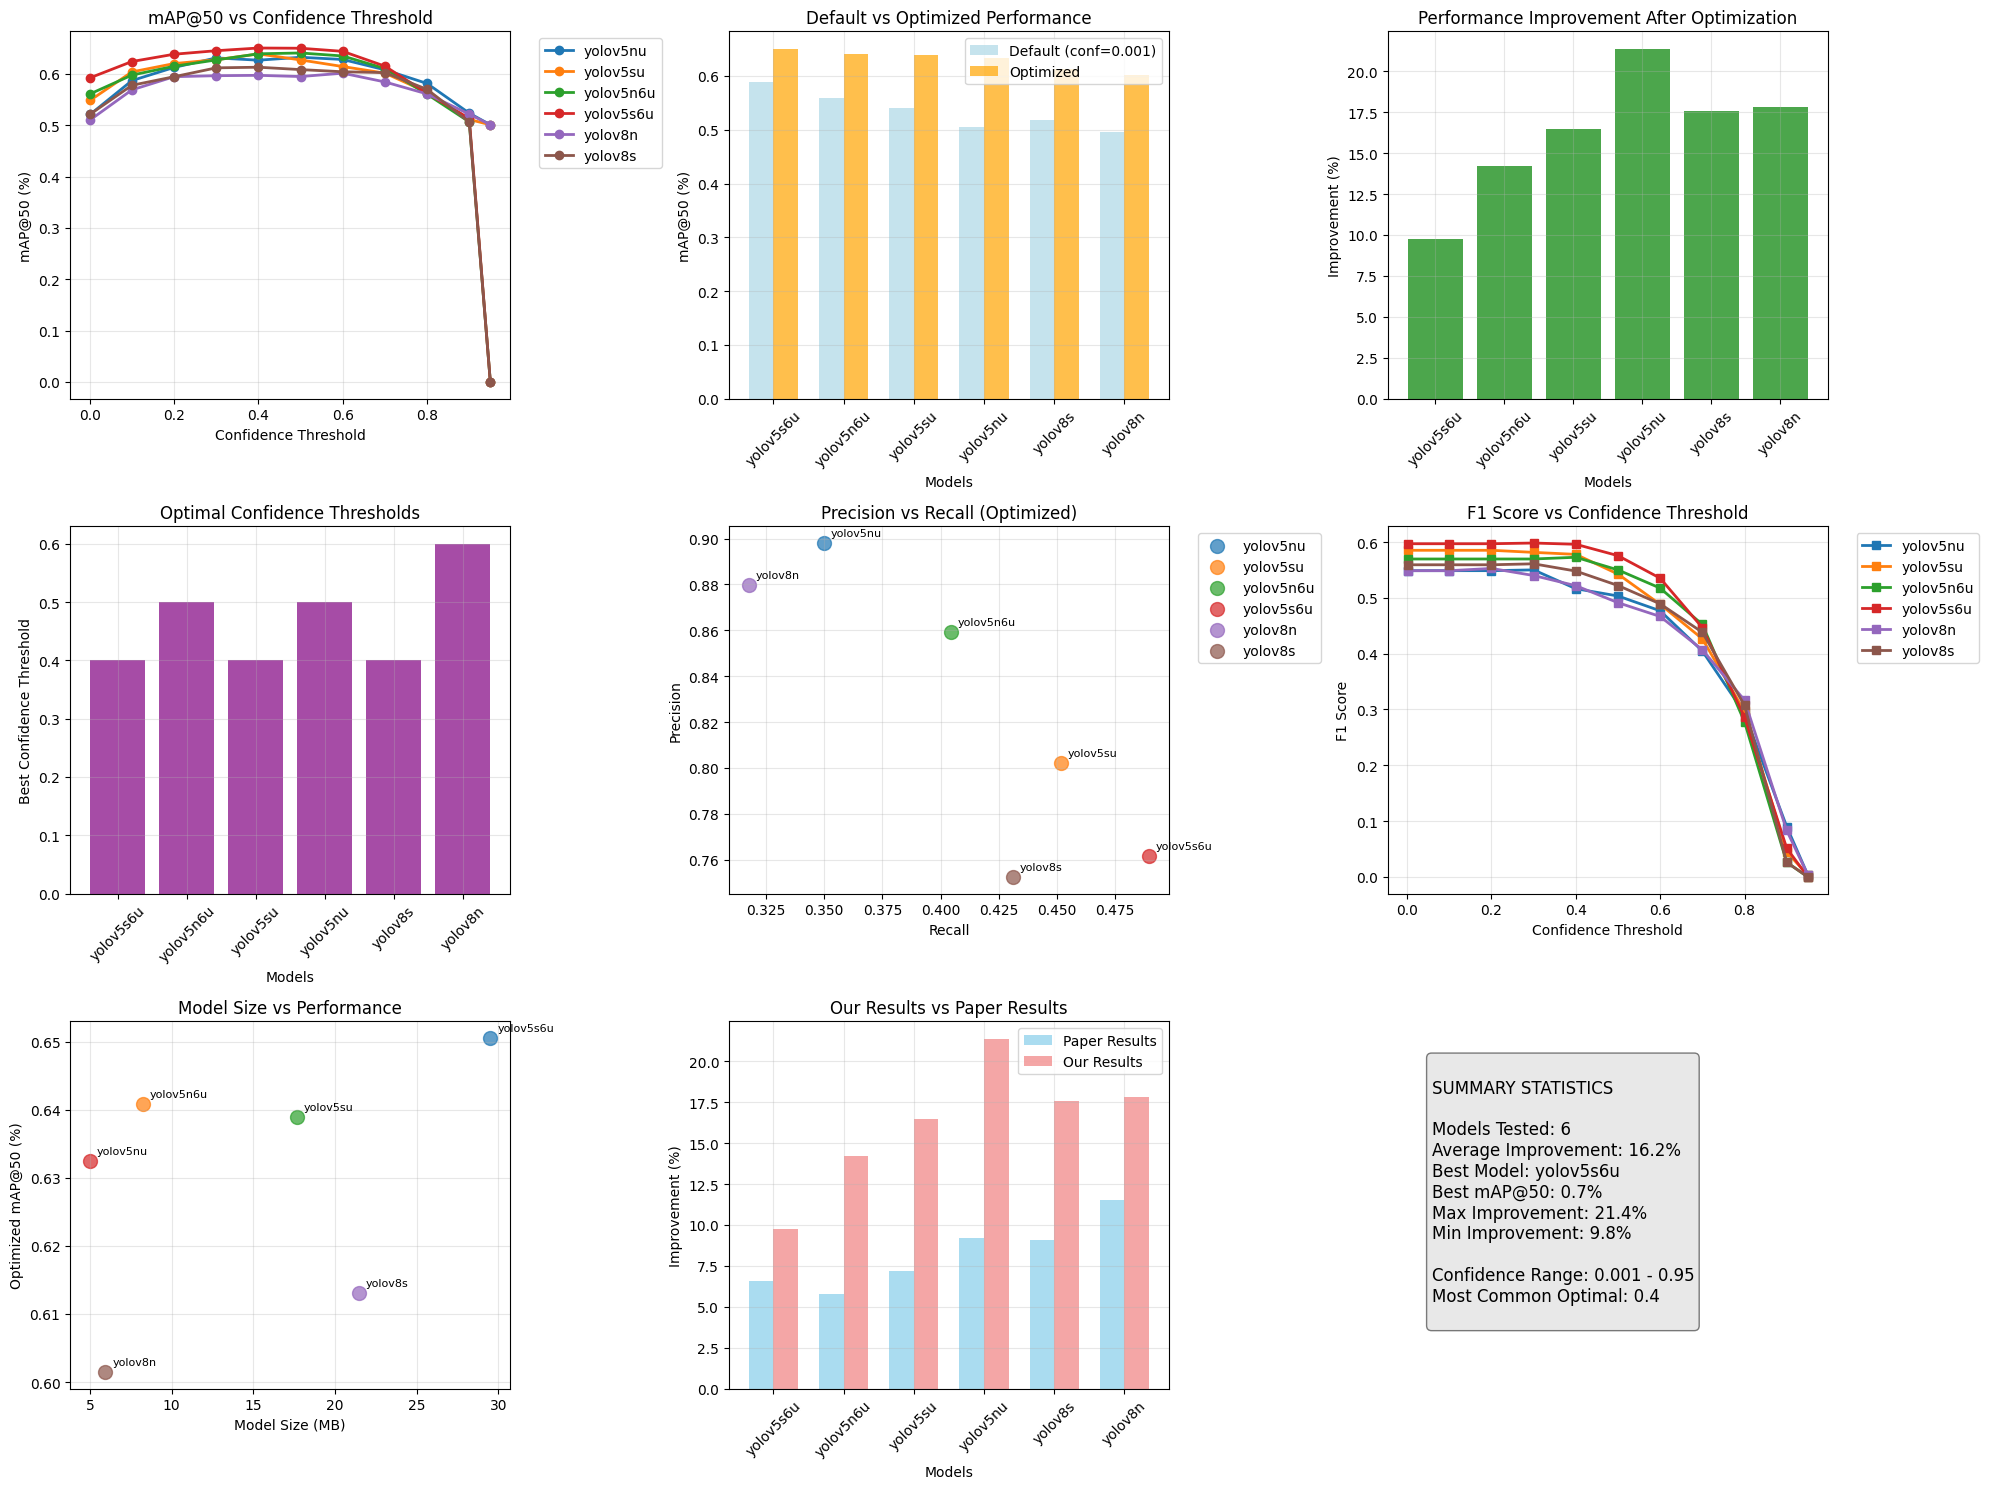


💾 Results saved to 'confidence_optimization_results.csv'


In [8]:
# ====================================
# VISUALIZATION
# ====================================

plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 1. Confidence Threshold Curves for Each Model
plt.subplot(3, 3, 1)
for model_name, results in optimization_results.items():
    if 'error' not in results:
        thresholds = list(results['threshold_results'].keys())
        map50_values = [results['threshold_results'][t]['map50'] for t in thresholds]
        plt.plot(thresholds, map50_values, marker='o', label=results['model_name'], linewidth=2)

plt.xlabel('Confidence Threshold')
plt.ylabel('mAP@50 (%)')
plt.title('mAP@50 vs Confidence Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 2. Performance Comparison Bar Chart
plt.subplot(3, 3, 2)
models = comparison_df['Model']
default_scores = comparison_df['Default mAP50']
optimized_scores = comparison_df['Optimized mAP50']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, default_scores, width, label='Default (conf=0.001)', alpha=0.7, color='lightblue')
plt.bar(x + width/2, optimized_scores, width, label='Optimized', alpha=0.7, color='orange')

plt.xlabel('Models')
plt.ylabel('mAP@50 (%)')
plt.title('Default vs Optimized Performance')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Improvement Percentage
plt.subplot(3, 3, 3)
improvements = comparison_df['Improvement (%)']
colors = ['green' if imp > 5 else 'orange' if imp > 0 else 'red' for imp in improvements]
plt.bar(models, improvements, color=colors, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Improvement (%)')
plt.title('Performance Improvement After Optimization')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Best Confidence Thresholds
plt.subplot(3, 3, 4)
best_confs = comparison_df['Best Confidence']
plt.bar(models, best_confs, color='purple', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Best Confidence Threshold')
plt.title('Optimal Confidence Thresholds')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. Precision vs Recall at Optimal Thresholds
plt.subplot(3, 3, 5)
for model_name, results in optimization_results.items():
    if 'error' not in results and results['best_metrics']:
        precision = results['best_metrics']['precision']
        recall = results['best_metrics']['recall']
        plt.scatter(recall, precision, s=100, label=results['model_name'], alpha=0.7)
        plt.annotate(results['model_name'], (recall, precision), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall (Optimized)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 6. F1 Score at Different Thresholds
plt.subplot(3, 3, 6)
for model_name, results in optimization_results.items():
    if 'error' not in results:
        thresholds = list(results['threshold_results'].keys())
        f1_values = [results['threshold_results'][t]['f1'] for t in thresholds]
        plt.plot(thresholds, f1_values, marker='s', label=results['model_name'], linewidth=2)

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 7. Model Size vs Optimized Performance
plt.subplot(3, 3, 7)
if 'training_results' in globals():
    for model_name in comparison_df['Model']:
        model_file = model_name + '.pt'
        if model_file in training_results and 'model_size_mb' in training_results[model_file]:
            size = training_results[model_file]['model_size_mb']
            perf = comparison_df[comparison_df['Model'] == model_name]['Optimized mAP50'].iloc[0]
            plt.scatter(size, perf, s=100, alpha=0.7)
            plt.annotate(model_name, (size, perf), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)

plt.xlabel('Model Size (MB)')
plt.ylabel('Optimized mAP@50 (%)')
plt.title('Model Size vs Performance')
plt.grid(True, alpha=0.3)

# 8. Comparison with Paper Results
plt.subplot(3, 3, 8)
paper_models = []
our_improvements = []
paper_improvements_vals = []

for _, row in comparison_df.iterrows():
    model_key = row['Model'].lower()
    if model_key in paper_improvements and paper_improvements[model_key] is not None:
        paper_models.append(row['Model'])
        our_improvements.append(row['Improvement (%)'])
        paper_improvements_vals.append(paper_improvements[model_key])

if paper_models:
    x = np.arange(len(paper_models))
    width = 0.35
    
    plt.bar(x - width/2, paper_improvements_vals, width, label='Paper Results', alpha=0.7, color='skyblue')
    plt.bar(x + width/2, our_improvements, width, label='Our Results', alpha=0.7, color='lightcoral')
    
    plt.xlabel('Models')
    plt.ylabel('Improvement (%)')
    plt.title('Our Results vs Paper Results')
    plt.xticks(x, paper_models, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Summary Statistics
plt.subplot(3, 3, 9)
plt.axis('off')
summary_text = f"""
SUMMARY STATISTICS

Models Tested: {len(comparison_df)}
Average Improvement: {avg_improvement:.1f}%
Best Model: {comparison_df.iloc[0]['Model']}
Best mAP@50: {comparison_df.iloc[0]['Optimized mAP50']:.1f}%
Max Improvement: {comparison_df['Improvement (%)'].max():.1f}%
Min Improvement: {comparison_df['Improvement (%)'].min():.1f}%

Confidence Range: {min(CONFIDENCE_THRESHOLDS)} - {max(CONFIDENCE_THRESHOLDS)}
Most Common Optimal: {comparison_df['Best Confidence'].mode().iloc[0] if len(comparison_df) > 0 else 'N/A'}
"""
plt.text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.savefig('confidence_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results to CSV
comparison_df.to_csv('confidence_optimization_results.csv', index=False)
print(f"\n💾 Results saved to 'confidence_optimization_results.csv'")


In [9]:
# ====================================
# PAPER-STYLE RESULTS TABLE
# ====================================

print("\n📋 DETAILED RESULTS TABLE (Paper Style)")
print("=" * 100)

# Create detailed table like in the paper
detailed_results = []
for model_name, results in optimization_results.items():
    if 'error' not in results:
        default_metrics = get_default_performance(trained_model_paths[model_name], data_yaml)
        
        detailed_results.append({
            'Method': results['model_name'],
            'Default mAP50': f"{results['default_map50']:.1f}",
            'Tuned mAP50': f"{results['optimized_map50']:.1f}",
            'Improvement': f"+{results['improvement_percent']:.1f}",
            'Best Conf': f"{results['best_confidence']:.3f}",
            'Precision': f"{results['best_metrics']['precision']:.3f}" if results['best_metrics'] else "N/A",
            'Recall': f"{results['best_metrics']['recall']:.3f}" if results['best_metrics'] else "N/A",
            'F1 Score': f"{results['best_metrics']['f1']:.3f}" if results['best_metrics'] else "N/A"
        })

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df.to_string(index=False))

# Generate LaTeX table for papers
print("\n📝 LATEX TABLE FOR PAPERS")
print("=" * 50)
latex_table = detailed_df.to_latex(index=False, escape=False)
print(latex_table)



📋 DETAILED RESULTS TABLE (Paper Style)
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2979.9±1523.6 MB/s, size: 2095.6 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        150        529      0.733      0.427      0.505      0.306
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.1ms postprocess per image


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2989.0±955.3 MB/s, size: 1777.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

                   all        150        529      0.746       0.46       0.54      0.345
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.6ms postprocess per image


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4360.2±1667.8 MB/s, size: 1864.7 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        150        529      0.772      0.452      0.559      0.337
Speed: 0.5ms preprocess, 5.7ms inference, 0.0ms loss, 1.6ms postprocess per image


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4498.4±1914.8 MB/s, size: 2080.1 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        150        529      0.755      0.488      0.589      0.346
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 1.7ms postprocess per image


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3503.0±806.4 MB/s, size: 2023.0 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        150        529      0.615      0.467      0.496      0.309
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.7ms postprocess per image


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4419.0±662.9 MB/s, size: 1853.4 KB)


val: Scanning /kaggle/working/taco_yolo_dataset/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

                   all        150        529      0.689      0.464      0.518      0.345
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 1.9ms postprocess per image


   Method Default mAP50 Tuned mAP50 Improvement Best Conf Precision Recall F1 Score
 yolov5nu           0.5         0.6       +21.4     0.500     0.898  0.350    0.503
 yolov5su           0.5         0.6       +16.5     0.400     0.802  0.452    0.578
yolov5n6u           0.6         0.6       +14.2     0.500     0.859  0.405    0.550
yolov5s6u           0.6         0.7        +9.8     0.400     0.762  0.490    0.596
  yolov8n           0.5         0.6       +17.8     0.600     0.880  0.318    0.467
  yolov8s           0.5         0.6       +17.6     0.400     0.752  0.431    0.548

📝 LATEX TABLE FOR PAPERS
\begin{tabular}{llllllll}
\toprule
Method & Default mAP50 & Tuned mAP50 & Improvement & Best Conf & Precision & Recall & F1 Score \\
\midrule
yolov5nu & 0.5 & 0.6 & +21.4 & 0.500 & 0.898 & 0.350 & 0.503 \\
yolov5su & 0.5 & 0.6 & +16.5 & 0.400 & 0.802 & 0.452 & 0.578 \\
yolov5n6u & 0.6 & 0.6 & +14.2 & 0.500 & 0.859 & 0.405 & 0.550 \\
yolov5s6u & 0.6 & 0.7 & +9.8 & 0.400 & 0.762 & 0.49

## Performance evaluation

In [10]:
# ====================================
# PERFORMANCE EVALUATION
# ====================================

def benchmark_model(model_path, data_yaml):
    """Benchmark model for latency and FPS"""
    model = YOLO(model_path)
    
    # Run benchmark
    from ultralytics.utils.benchmarks import benchmark
    
    # Benchmark the model
    results = benchmark(
        model=model_path,
        data=data_yaml,
        imgsz=640,
        half=False,
        device=0 if torch.cuda.is_available() else 'cpu'
    )
    
    return results

def extract_metrics(training_result):
    """Extract key metrics from training results"""
    if 'error' in training_result:
        return None
        
    val_results = training_result['val_results']
    
    metrics = {
        'model_name': training_result['model_name'].replace('.pt', ''),
        'training_time_hours': training_result['training_time'] / 3600,
        'model_size_mb': training_result['model_size_mb'],
        'precision': val_results.box.mp if hasattr(val_results.box, 'mp') else 0,
        'recall': val_results.box.mr if hasattr(val_results.box, 'mr') else 0,
        'f1_score': 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr) if hasattr(val_results.box, 'mp') and hasattr(val_results.box, 'mr') else 0,
        'map50': val_results.box.map50 if hasattr(val_results.box, 'map50') else 0,
        'map50_95': val_results.box.map if hasattr(val_results.box, 'map') else 0
    }
    
    # Benchmark for latency
    try:
        benchmark_results = benchmark_model(training_result['best_model_path'], data_yaml)
        # Extract FPS/latency from benchmark results
        metrics['fps'] = benchmark_results.get('FPS', 0)
        metrics['latency_ms'] = 1000 / metrics['fps'] if metrics['fps'] > 0 else 0
    except:
        metrics['fps'] = 0
        metrics['latency_ms'] = 0
    
    return metrics

# Extract metrics for all successful models
metrics_data = []
for model_name, result in training_results.items():
    metrics = extract_metrics(result)
    if metrics:
        metrics_data.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(metrics_data)

# Display results
print("🏆 YOLO MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('yolo_model_comparison.csv', index=False)
print("\n📊 Results saved to 'yolo_model_comparison.csv'")


🏆 YOLO MODEL PERFORMANCE COMPARISON
model_name  training_time_hours  model_size_mb  precision   recall  f1_score    map50  map50_95  fps  latency_ms
  yolov5nu             0.855708       5.019282   0.654937 0.421550  0.512944 0.484306  0.305885    0           0
  yolov5su             1.017117      17.653560   0.663016 0.494666  0.566600 0.536563  0.351088    0           0
 yolov5n6u             1.807634       8.238727   0.706710 0.483932  0.574479 0.562554  0.344317    0           0
 yolov5s6u             2.364112      29.505084   0.713909 0.512287  0.596522 0.586681  0.352744    0           0
   yolov8n             0.878454       5.952243   0.675918 0.446125  0.537491 0.500133  0.320047    0           0
   yolov8s             1.062678      21.467563   0.638721 0.497967  0.559629 0.527124  0.355919    0           0

📊 Results saved to 'yolo_model_comparison.csv'


## Results Visualisation

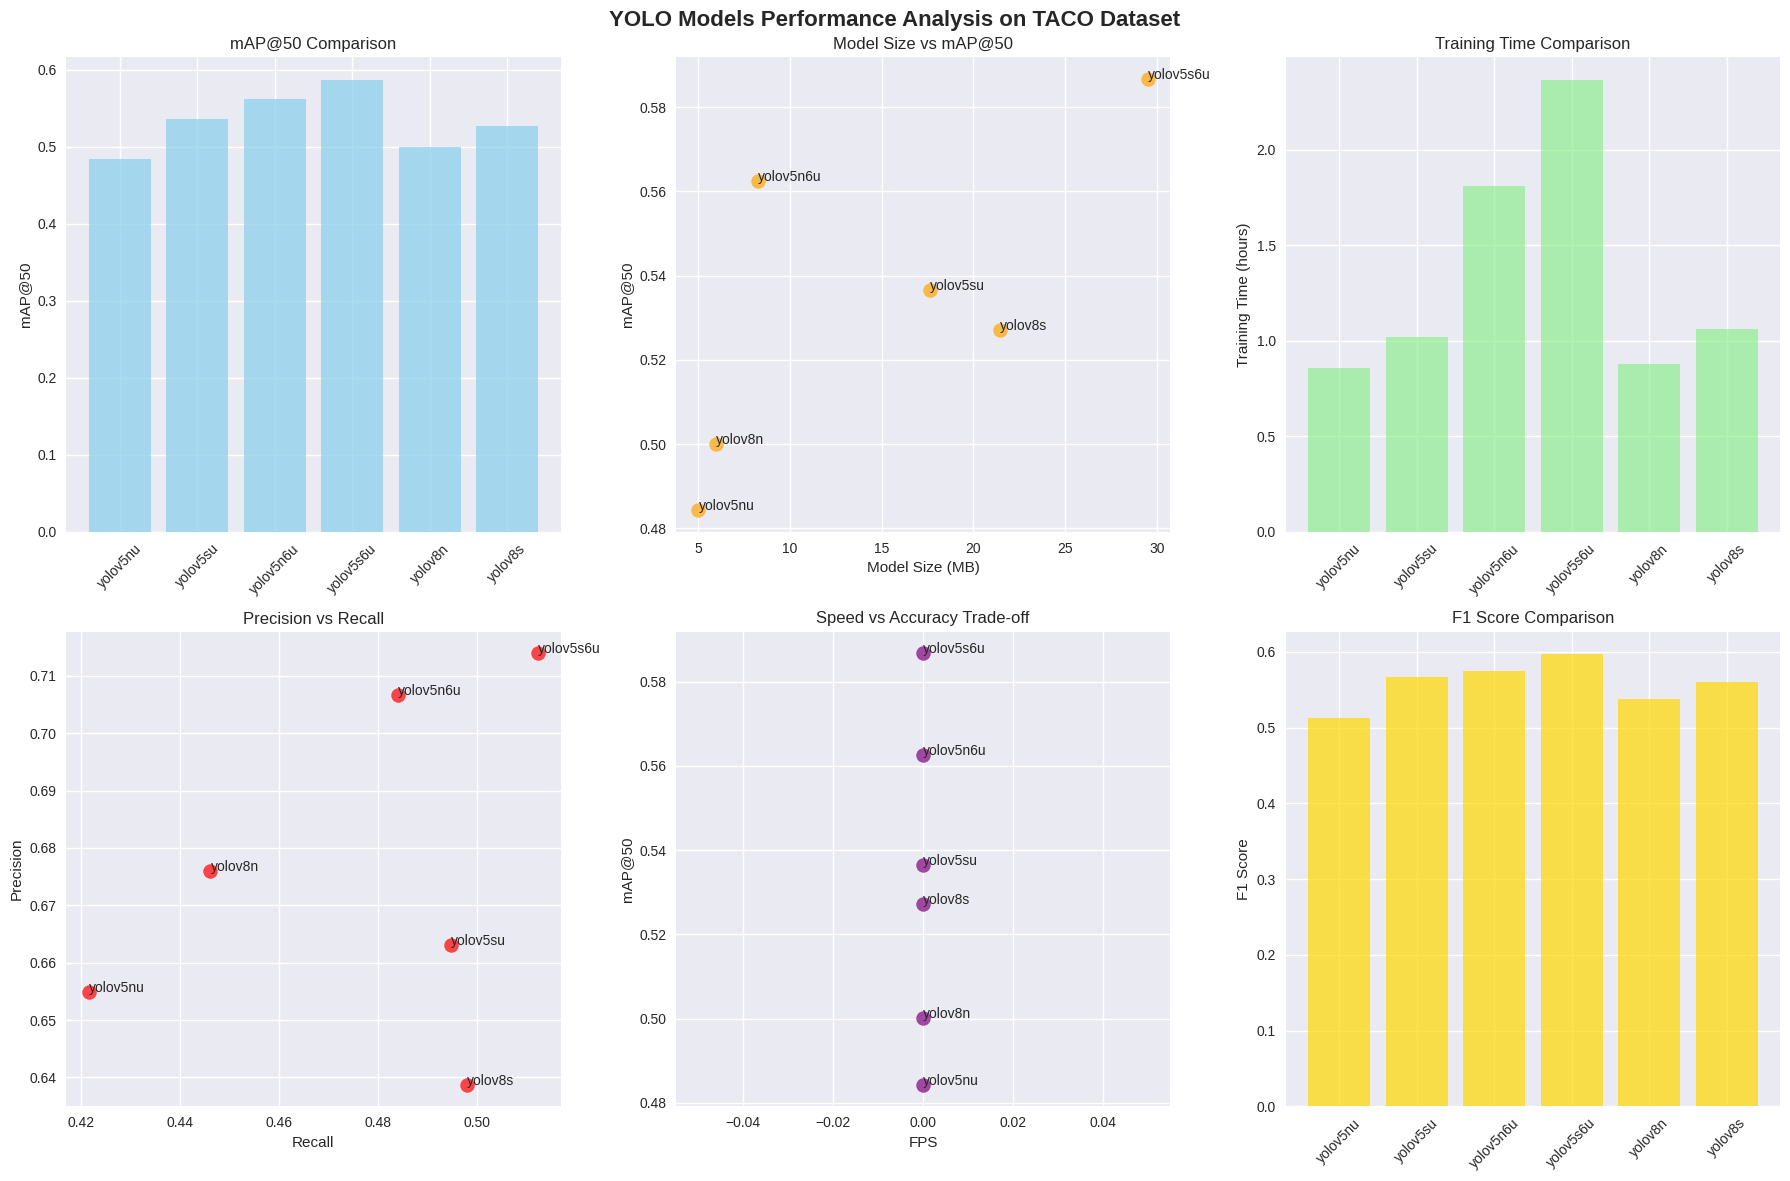


📋 PERFORMANCE SUMMARY
model_name  precision  recall  f1_score  map50  training_time_hours  model_size_mb  fps
  yolov5nu      0.655   0.422     0.513  0.484                0.856          5.019    0
  yolov5su      0.663   0.495     0.567  0.537                1.017         17.654    0
 yolov5n6u      0.707   0.484     0.574  0.563                1.808          8.239    0
 yolov5s6u      0.714   0.512     0.597  0.587                2.364         29.505    0
   yolov8n      0.676   0.446     0.537  0.500                0.878          5.952    0
   yolov8s      0.639   0.498     0.560  0.527                1.063         21.468    0

🥇 TOP PERFORMERS
Best mAP@50: yolov5s6u (0.587)
Fastest Training: yolov5nu (0.86 hours)
Smallest Model: yolov5nu (5.0 MB)
Highest FPS: yolov5nu (0.0 FPS)
Best F1 Score: yolov5s6u (0.597)


In [11]:
# ====================================
# RESULTS VISUALIZATION
# ====================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('YOLO Models Performance Analysis on TACO Dataset', fontsize=16, fontweight='bold')

# 1. mAP50 Comparison
axes[0, 0].bar(results_df['model_name'], results_df['map50'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('mAP@50 Comparison')
axes[0, 0].set_ylabel('mAP@50')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Model Size vs mAP50
axes[0, 1].scatter(results_df['model_size_mb'], results_df['map50'], s=100, alpha=0.7, c='orange')
axes[0, 1].set_title('Model Size vs mAP@50')
axes[0, 1].set_xlabel('Model Size (MB)')
axes[0, 1].set_ylabel('mAP@50')
for i, model in enumerate(results_df['model_name']):
    axes[0, 1].annotate(model, (results_df['model_size_mb'].iloc[i], results_df['map50'].iloc[i]))

# 3. Training Time Comparison
axes[0, 2].bar(results_df['model_name'], results_df['training_time_hours'], color='lightgreen', alpha=0.7)
axes[0, 2].set_title('Training Time Comparison')
axes[0, 2].set_ylabel('Training Time (hours)')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Precision vs Recall
axes[1, 0].scatter(results_df['recall'], results_df['precision'], s=100, alpha=0.7, c='red')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
for i, model in enumerate(results_df['model_name']):
    axes[1, 0].annotate(model, (results_df['recall'].iloc[i], results_df['precision'].iloc[i]))

# 5. FPS vs mAP50
axes[1, 1].scatter(results_df['fps'], results_df['map50'], s=100, alpha=0.7, c='purple')
axes[1, 1].set_title('Speed vs Accuracy Trade-off')
axes[1, 1].set_xlabel('FPS')
axes[1, 1].set_ylabel('mAP@50')
for i, model in enumerate(results_df['model_name']):
    axes[1, 1].annotate(model, (results_df['fps'].iloc[i], results_df['map50'].iloc[i]))

# 6. F1 Score Comparison
axes[1, 2].bar(results_df['model_name'], results_df['f1_score'], color='gold', alpha=0.7)
axes[1, 2].set_title('F1 Score Comparison')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('yolo_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Performance Summary Table
print("\n📋 PERFORMANCE SUMMARY")
print("=" * 100)
summary_df = results_df[['model_name', 'precision', 'recall', 'f1_score', 'map50', 'training_time_hours', 'model_size_mb', 'fps']].round(3)
print(summary_df.to_string(index=False))

# Best performing models
print("\n🥇 TOP PERFORMERS")
print("=" * 50)
print(f"Best mAP@50: {results_df.loc[results_df['map50'].idxmax(), 'model_name']} ({results_df['map50'].max():.3f})")
print(f"Fastest Training: {results_df.loc[results_df['training_time_hours'].idxmin(), 'model_name']} ({results_df['training_time_hours'].min():.2f} hours)")
print(f"Smallest Model: {results_df.loc[results_df['model_size_mb'].idxmin(), 'model_name']} ({results_df['model_size_mb'].min():.1f} MB)")
print(f"Highest FPS: {results_df.loc[results_df['fps'].idxmax(), 'model_name']} ({results_df['fps'].max():.1f} FPS)")
print(f"Best F1 Score: {results_df.loc[results_df['f1_score'].idxmax(), 'model_name']} ({results_df['f1_score'].max():.3f})")
